In [91]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.optimize import curve_fit
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output
%matplotlib inline


In [2]:
# 2spot3 location 119,55 is the nice one

In [3]:
cd /Users/austinmcdonald/Desktop/test/cut/Ba/2Spot3/

/Users/austinmcdonald/Desktop/test/cut/Ba/2Spot3


In [4]:
files = os.listdir()
files = [x for x in files if x != '.DS_Store']
#files

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [84]:
eCoeff = 0.01160
eOffset= 1917
z=0
w=1

Shape = 221
xvs = np.arange(0,Shape)
neighborhood_size = 9
Row = int(4) # define the area to take around the spots
Col = int(4) # define the area to take around the spots

DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
Datatot = DataSub
fitts = []

AllPairs =[]
SpotInfo2 = []

ImageB = []
        

MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
for x in range(700,750):
    Images = np.array(Image.open(files[x]))
    Images = eCoeffM*(Images - eOffsetM)
    ImageFit = []
    for y in range(0,Shape):
        coefs = poly.polyfit(xvs,Images[y], 2) # fits 2nd order poly 
        ffit  = poly.polyval(xvs, coefs)
        ImageFit.append(ffit)
    MeanFit+=np.array(ImageFit)
MeanFit = MeanFit/50


for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM) - MeanFit
    DataSub += Images


data = DataSub

threshold = np.mean(data)+3*np.std(data)  #////////////////////////////////////////////////////////////

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
Pairs = []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)
    Pairs.append((x_center,y_center))
for item in Pairs:
    if item not in AllPairs:
        AllPairs.append(item) 


Images = None
ImageB = None
data   = None
Slices = None
labeled= None
num_objects=None

############################################################## 
Xc=[]
Yc=[]
for qw in range(0,len(AllPairs)):
    XX = AllPairs[qw][0]
    YY = AllPairs[qw][1]
    if XX>10 and XX<210 and YY>10 and YY<210:
        Xc.append(XX)
        Yc.append(YY)

        
for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])))
    Images = eCoeffM*(Images - eOffsetM) - MeanFit
    Images[Images < 0] = 0 

    SpotInfoHolder = []

    for we in range(0,len(Xc)):
        Xindex = int(Xc[we])
        Yindex = int(Yc[we])

        spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot = spot1[2:7,2:7]
        SpotRemove = np.zeros(5**2).reshape((5,5))
        spot2[2:7,2:7]=SpotRemove
        spotB = spot2

        ATot = spot.sum()
        ATotB = spot2.sum()
        SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

########################################################################################  

    clear_output()
    print('Finding all areas in dataset'+' '+str(z)) 
    print('Finding all areas in folder'+' '+str(w)) 

Par = len(AllPairs)
AVG = 5
Signal = []
BackG  = []
SignalF = []
BackGF  = []
sigmas = []
Tau = []
Mnumb = 5
for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,4]
    HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))
    aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))
    vals =np.arange(0,len(aa))
    sigmas.append(np.sqrt(aa))
    coefs = poly.polyfit(vals,aaB, 3)
    ffit  = poly.polyval(vals, coefs)
    Sig = np.array(aa-ffit*(25/56))
    bac = np.array(aaB-ffit)

    SigF = np.array(HoldArea)
    bacF = np.array(HoldAreaB)
    
    meanI = np.mean(Sig[:Mnumb])
    meanE = np.mean(Sig[-Mnumb:])
    meanM = np.mean(Sig)
    T = len(Sig)
    tau = ((meanM - meanE)/(meanI -meanE))*T
    Tau.append(tau)
    
    Signal.append(Sig)
    BackG.append(bac)
    SignalF.append(SigF)
    BackGF.append(bacF)
    
Tau2 = []
Offset = 5
for x in range(0,Par):
    TauH = Tau[x]
    for q in range(0,20):
        meanI = np.mean(Signal[x][:int(TauH)-Offset])
        meanE = np.mean(Signal[x][int(TauH)+Offset:])
        T = len(Signal[x])
        meanM = np.mean(Signal[x])
        tau = ((meanM - meanE)/(meanI -meanE))*T 
        if tau != tau:
            tau = -10
        TauH = tau
    Tau2.append(TauH)

Tau3 = []
Offset = 3
for x in range(0,Par):
    TauH = Tau2[x]
    for q in range(0,20):
        meanI = np.mean(Signal[x][:int(TauH)-Offset])
        meanE = np.mean(Signal[x][int(TauH)+Offset:])
        T = len(Signal[x])
        meanM = np.mean(Signal[x])
        tau = ((meanM - meanE)/(meanI -meanE))*T 
        if tau != tau:
            tau = -10
        TauH = tau
    Tau3.append(TauH)

#data = []
#PairsMade = []
chiSQUAR = []
chiLINE = []
#chiFIT=[]
chiRa = []
meanDif = []
#Dtau = []
areaS=[]
areaSS=[]
areaPre=[]
areaPost=[]
ITEN=[]
MeanI=[]
MeanE=[]
chiDiff = []
Offset =3
NUMBER = 0
errors=[]
fitparam=[]
for x in range(0,Par):
    TauH   = Tau3[x]
    #if TauH>0 and TauH<150:

    Data = Signal[x] 
    DataLeft  = Data[:int(TauH)-Offset]
    DataRight = Data[int(TauH)+Offset:]
    sigmasLeft  = sigmas[x][:int(TauH)-Offset]
    sigmasRight = sigmas[x][int(TauH)+Offset:]
    mean  = np.mean(Data)
    meanI  = np.mean(DataLeft)
    meanE  = np.mean(DataRight)


    chiHIGH = np.sum((DataLeft - meanI)**2/abs(sigmasLeft)**2)/749
    chiLOW = np.sum((DataRight - meanE)**2/abs(sigmasRight)**2)/749


    val = np.arange(0,len(Data),1)
    coefs=np.polyfit(val,Data,1)    
    fitparam.append(coefs)
    ffit  = coefs[0]*val+coefs[1]
    chiFit  = np.sum((ffit - Data)**2/abs(sigmas[x])**2)/748



    if meanI-meanE>100 and ((chiLOW+chiHIGH) - chiFit)<1:
        NUMBER += 1

    chiRa.append((chiLOW+chiHIGH)/ chiFit)
    meanDif.append(meanI-meanE)
    areaS.append(ffit)
    areaSS.append(Data)
    areaPre.append(DataLeft)
    areaPost.append(DataRight)
    MeanI.append(meanI)
    MeanE.append(meanE)
    errors.append(sigmas[x])
    chiDiff.append((chiLOW+chiHIGH) - chiFit)
    chiSQUAR.append(chiLOW+chiHIGH)
    chiLINE.append(chiFit)
print("done!")

Finding all areas in dataset 0
Finding all areas in folder 1
done!


//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
len(Tau3)

156

In [44]:
a = np.array([0,1,2,3,4,5,6,7])
a[:3]

array([0, 1, 2])

Chi Square =  0.887856735353
Chi Line =  6.95756865743
Square < Line = good
Chi Diff =  -6.06971192207
Chi Ratio =  0.127610201073
ffit slope -1.57767208776
ffit intercept 179.488164521


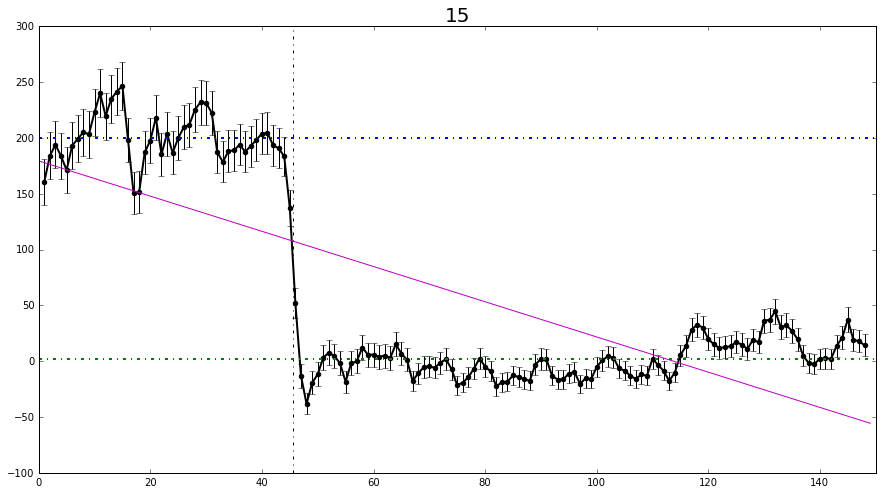

Chi Square =  1.09646097716
Chi Line =  3.65321222364
Square < Line = good
Chi Diff =  -2.55675124648
Chi Ratio =  0.300136129531
ffit slope -1.03559606223
ffit intercept 128.023175264


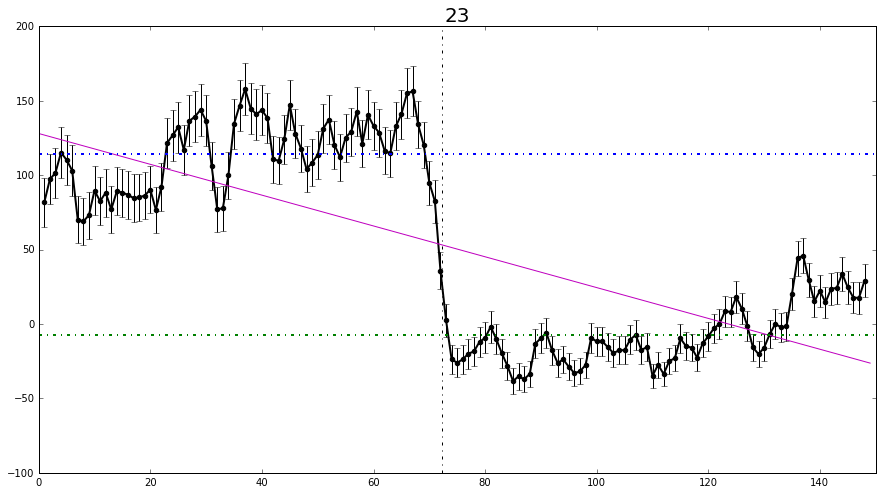

Chi Square =  0.995855527005
Chi Line =  1.99834741922
Square < Line = good
Chi Diff =  -1.00249189222
Chi Ratio =  0.498339536672
ffit slope -0.905264489029
ffit intercept 110.768447114


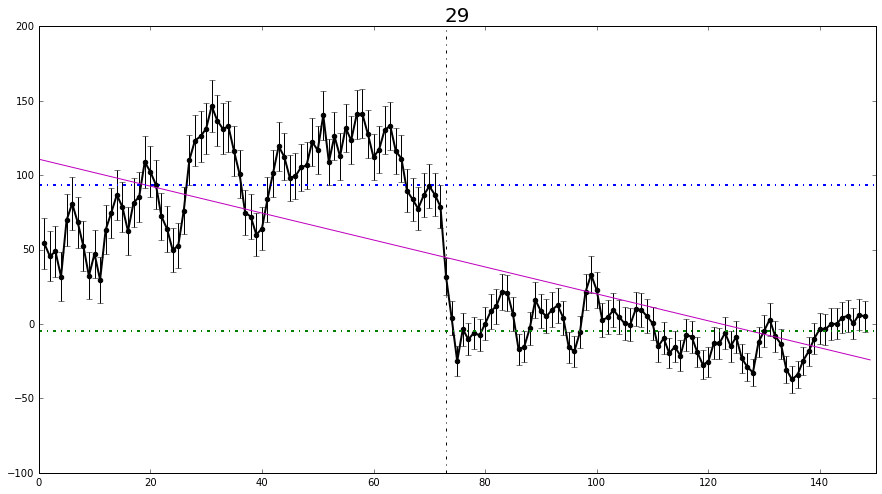

Chi Square =  2.1186031592
Chi Line =  2.50175630705
Square < Line = good
Chi Diff =  -0.383153147853
Chi Ratio =  0.846846334804
ffit slope -1.05650992931
ffit intercept 179.431132038


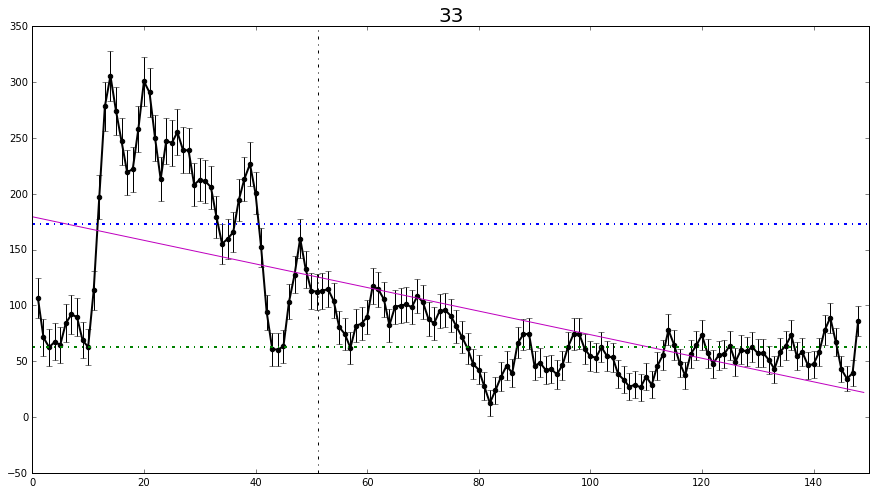

Chi Square =  0.869247378922
Chi Line =  2.19457150427
Square < Line = good
Chi Diff =  -1.32532412535
Chi Ratio =  0.396089795766
ffit slope -1.13145793598
ffit intercept 123.997901131


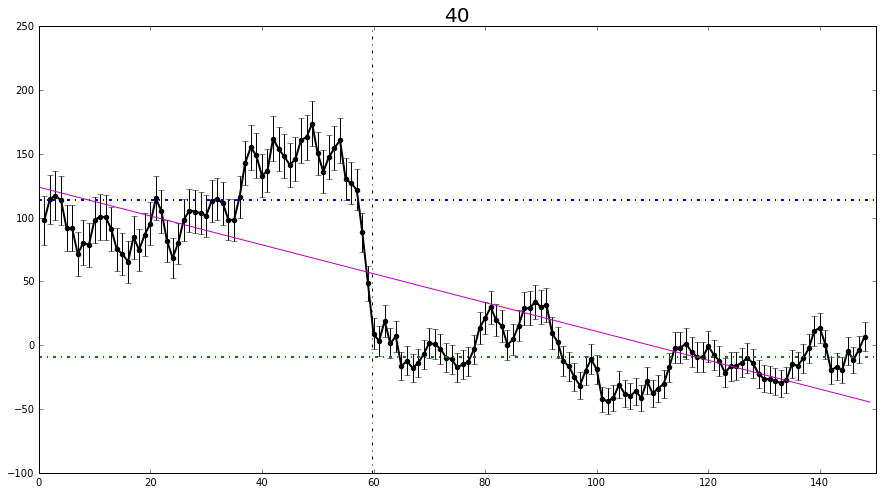

Chi Square =  1.28063443177
Chi Line =  3.04896289789
Square < Line = good
Chi Diff =  -1.76832846612
Chi Ratio =  0.420022963434
ffit slope -2.38462079758
ffit intercept 393.405853592


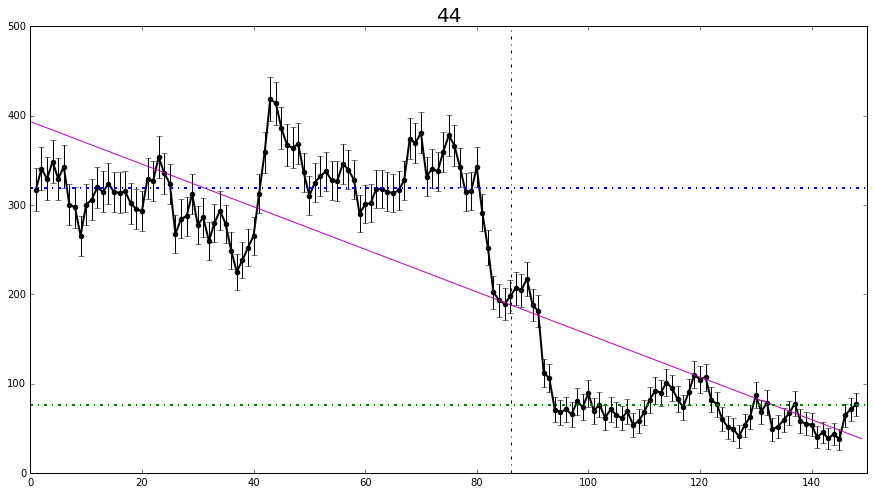

Chi Square =  1.51553139476
Chi Line =  3.58707197598
Square < Line = good
Chi Diff =  -2.07154058122
Chi Ratio =  0.42249818373
ffit slope -1.10944262932
ffit intercept 169.936359573


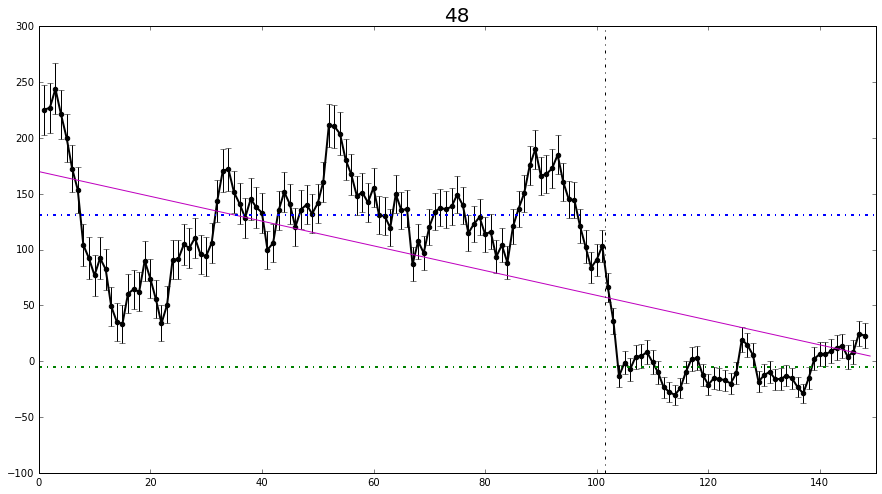

Chi Square =  2.08361339743
Chi Line =  3.62999595698
Square < Line = good
Chi Diff =  -1.54638255955
Chi Ratio =  0.573998820419
ffit slope -1.00156411533
ffit intercept 144.792199998


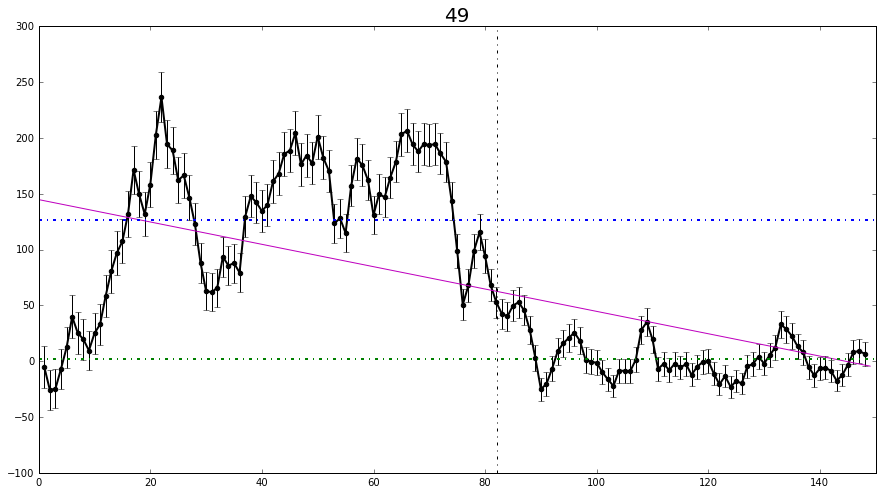

Chi Square =  0.872477648127
Chi Line =  2.38392964864
Square < Line = good
Chi Diff =  -1.51145200052
Chi Ratio =  0.365982967921
ffit slope -0.490549502784
ffit intercept 71.8680012277


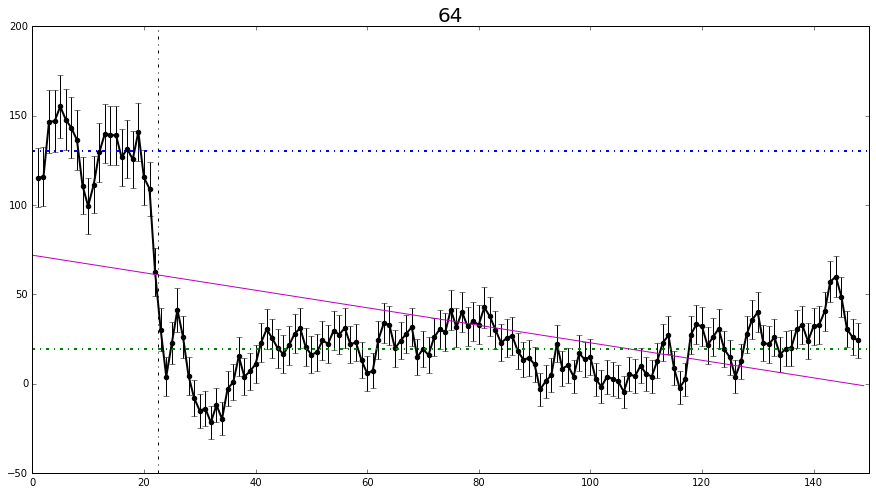

Chi Square =  2.54907020282
Chi Line =  2.735325557
Square < Line = good
Chi Diff =  -0.186255354182
Chi Ratio =  0.931907427361
ffit slope -1.22617592262
ffit intercept 126.46902616


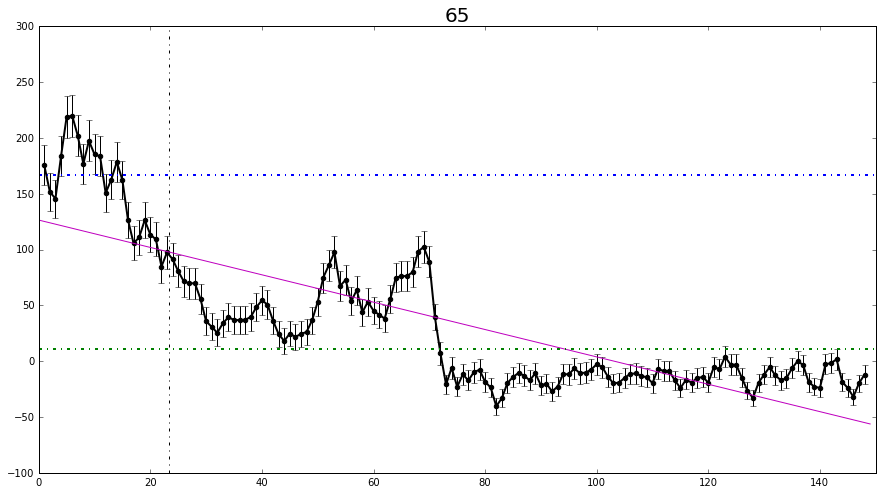

Chi Square =  2.05916124661
Chi Line =  8.29847238246
Square < Line = good
Chi Diff =  -6.23931113585
Chi Ratio =  0.248137386221
ffit slope -2.62556451593
ffit intercept 311.799242537


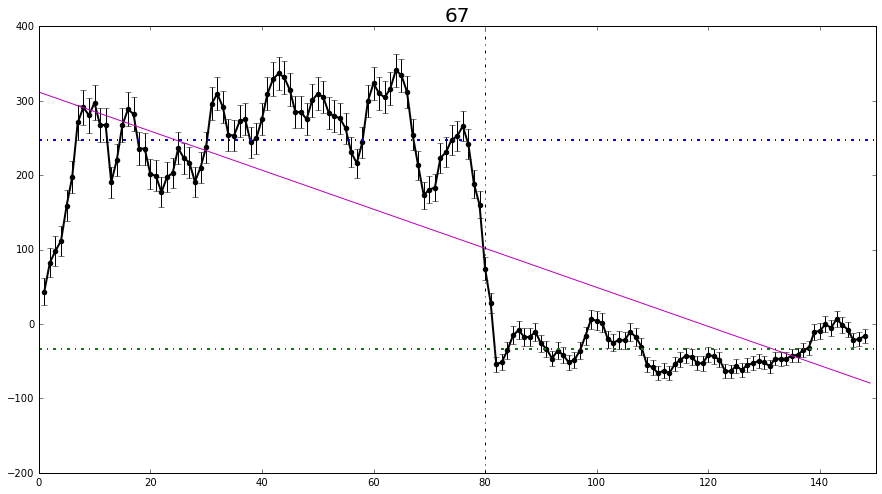

Chi Square =  4.48669414599
Chi Line =  3.97701588784
Square > Line = bad
Chi Diff =  0.509678258154
Chi Ratio =  1.12815595223
ffit slope -0.921551476003
ffit intercept 214.993073916


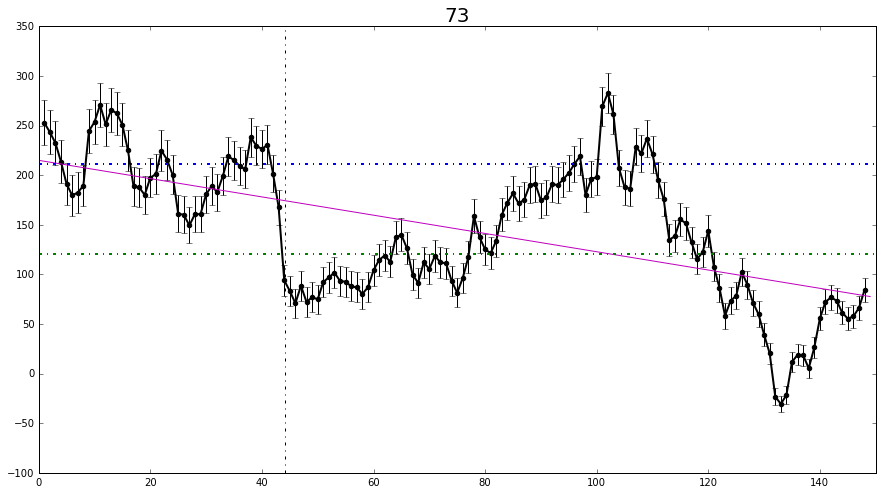

Chi Square =  1.72587884133
Chi Line =  2.6595311992
Square < Line = good
Chi Diff =  -0.933652357871
Chi Ratio =  0.648941002027
ffit slope -0.728956071703
ffit intercept 87.9785965904


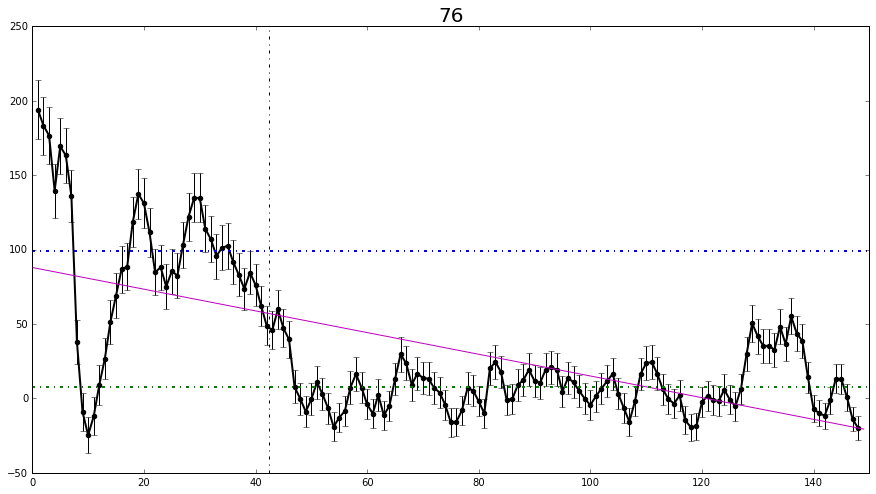

Chi Square =  2.4912994257
Chi Line =  4.36008418277
Square < Line = good
Chi Diff =  -1.86878475707
Chi Ratio =  0.571387918505
ffit slope -1.31006406996
ffit intercept 156.74128763


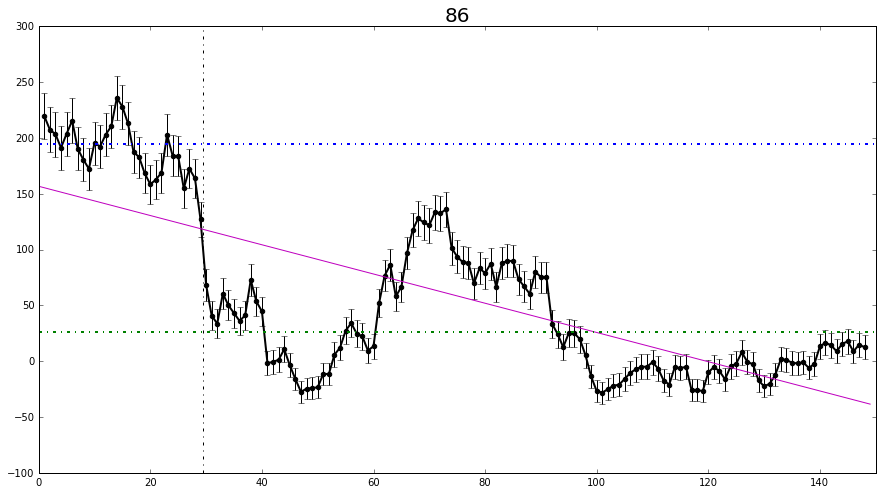

Chi Square =  1.04798140491
Chi Line =  1.56125148944
Square < Line = good
Chi Diff =  -0.513270084531
Chi Ratio =  0.671244454848
ffit slope -0.906443195513
ffit intercept 178.061870994


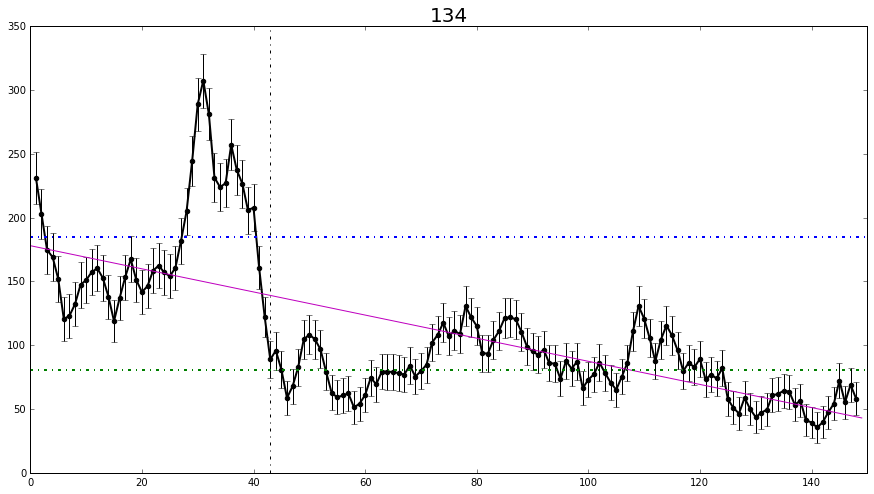

In [89]:
for x in range(0,len(Tau3)):
    if meanDif[x]>90 :#and chiDiff[x]<-0.5:#chiSQUAR[x]<chiLINE[x]:
        plt.figure(figsize=(15,8))
        vals =np.arange(0,len(areaSS[x]))
        plt.title(x,fontsize=20)
        print('Chi Square = ',chiSQUAR[x])
        print('Chi Line = ',chiLINE[x])
        if chiSQUAR[x]>chiLINE[x]:
            print('Square > Line = bad')
        else:
            print('Square < Line = good')   
        print('Chi Diff = ',chiDiff[x])
        print('Chi Ratio = ',chiRa[x])
        print('ffit slope',fitparam[x][0])
        print('ffit intercept',fitparam[x][1])
        avg=3
        
        smo=running_mean(areaSS[x],avg)
        vsmo=running_mean(vals,avg)
        esmo=running_mean(errors[x],avg)
        plt.plot(vsmo,smo,color='k',linewidth=2)
        plt.scatter(vsmo,smo,color='k')
        plt.errorbar(vsmo,smo,yerr=esmo,color='k',fmt='.')
        
        plt.plot(vals,areaS[x],color='m',linewidth=1)
        plt.axvline(Tau3[x],linestyle ='-.',color='k')
        plt.axhline(MeanI[x],linestyle ='-.',color='b',linewidth=2)
        plt.axhline(MeanE[x],linestyle ='-.',color='g',linewidth=2)
        
        plt.xlim(0,150)
        plt.show()

Chi Square =  0.764327914187
Chi Line =  0.100013607112
Square > Line = bad
Chi Diff =  0.664314307075
Chi Ratio =  7.6422392538
Chi Square v2 =  0.0591325136766
Chi Line v2 =  2.3502695144
Square < Line = good
Chi Diff  v2=  -2.29113700073
Chi Ratio v2=  0.0251598862659


//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


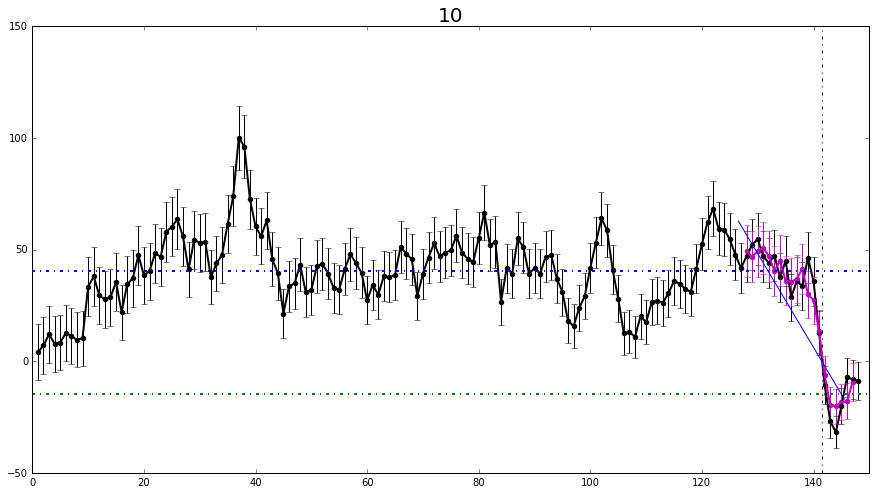

Chi Square =  0.887856735353
Chi Line =  1.80632595888
Square < Line = good
Chi Diff =  -0.918469223522
Chi Ratio =  0.491526311179
Chi Square v2 =  0.211287788209
Chi Line v2 =  0.816529765807
Square < Line = good
Chi Diff  v2=  -0.605241977598
Chi Ratio v2=  0.258763118084


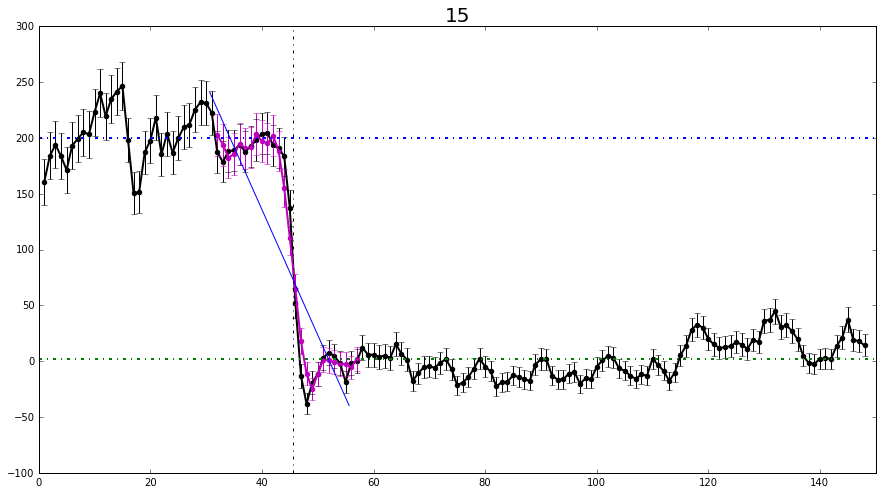

Chi Square =  1.03445974909
Chi Line =  0.0711851525463
Square > Line = bad
Chi Diff =  0.963274596542
Chi Ratio =  14.5319594337
Chi Square v2 =  0.128415044558
Chi Line v2 =  0.133513868668
Square < Line = good
Chi Diff  v2=  -0.00509882410997
Chi Ratio v2=  0.961810528293


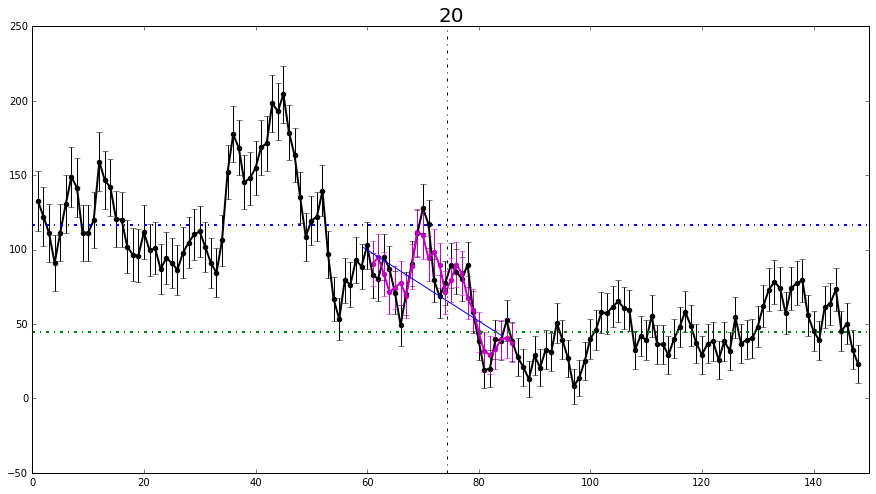

Chi Square =  2.43946896509
Chi Line =  0.114121893497
Square > Line = bad
Chi Diff =  2.32534707159
Chi Ratio =  21.3759944769
Chi Square v2 =  0.1314920315
Chi Line v2 =  0.123424184266
Square > Line = bad
Chi Diff  v2=  0.008067847234
Chi Ratio v2=  1.06536682646


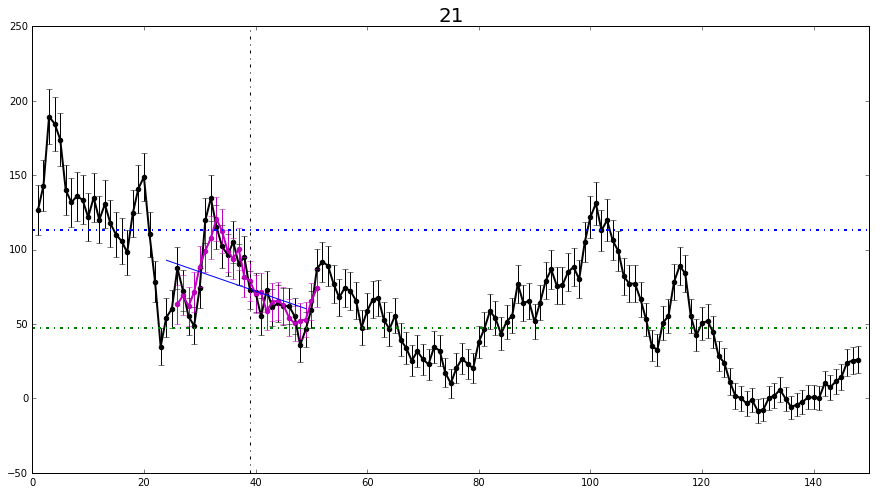

Chi Square =  1.09646097716
Chi Line =  6.35998059406
Square < Line = good
Chi Diff =  -5.2635196169
Chi Ratio =  0.172400050746
Chi Square v2 =  0.216335376615
Chi Line v2 =  0.893575723257
Square < Line = good
Chi Diff  v2=  -0.677240346642
Chi Ratio v2=  0.242100776671


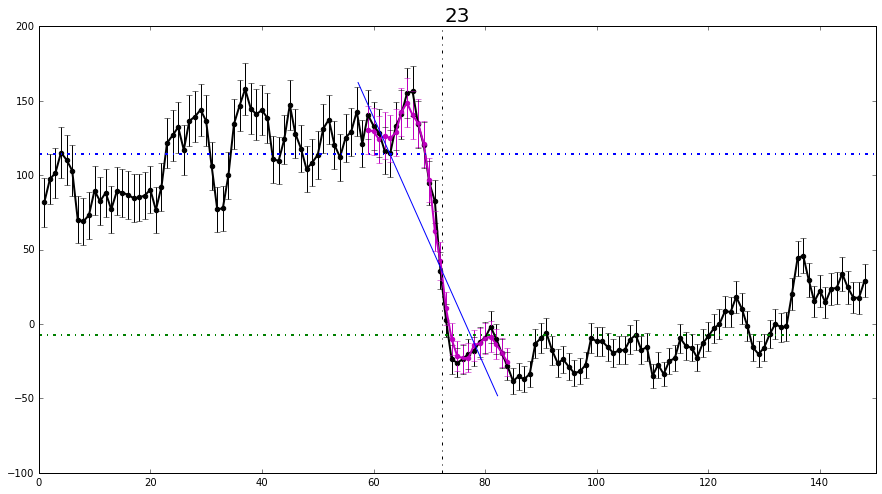

Chi Square =  0.84277254524
Chi Line =  64.0744787505
Square < Line = good
Chi Diff =  -63.2317062052
Chi Ratio =  0.0131530144556
Chi Square v2 =  0.117051630011
Chi Line v2 =  1.14520685488
Square < Line = good
Chi Diff  v2=  -1.02815522487
Chi Ratio v2=  0.102210032635


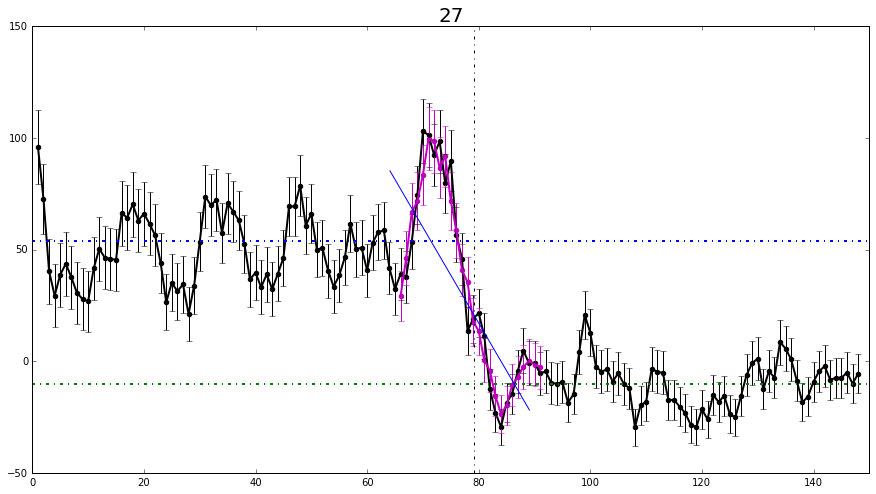

Chi Square =  0.995855527005
Chi Line =  3.1047268773
Square < Line = good
Chi Diff =  -2.10887135029
Chi Ratio =  0.320754632005
Chi Square v2 =  0.142348427644
Chi Line v2 =  1.39885449627
Square < Line = good
Chi Diff  v2=  -1.25650606862
Chi Ratio v2=  0.101760710655


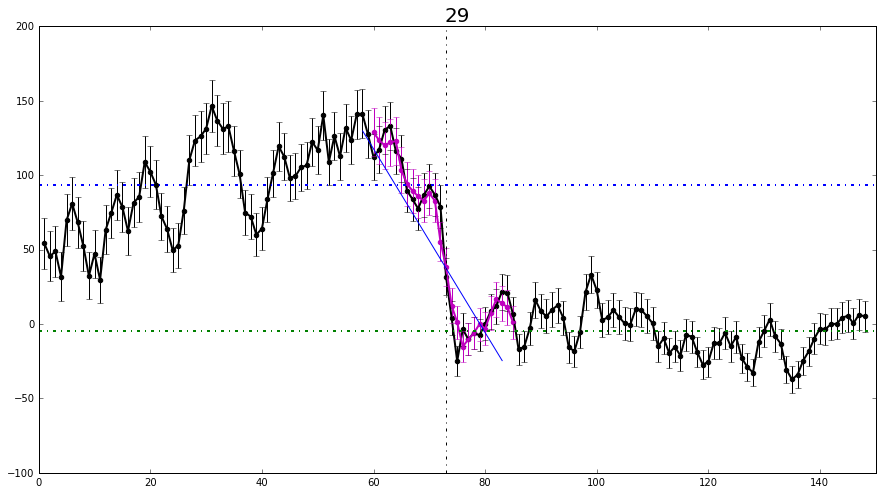

Chi Square =  0.854205324001
Chi Line =  0.270404210307
Square > Line = bad
Chi Diff =  0.583801113694
Chi Ratio =  3.15899417036
Chi Square v2 =  0.107325275471
Chi Line v2 =  0.0203850805208
Square > Line = bad
Chi Diff  v2=  0.0869401949504
Chi Ratio v2=  5.26489337934


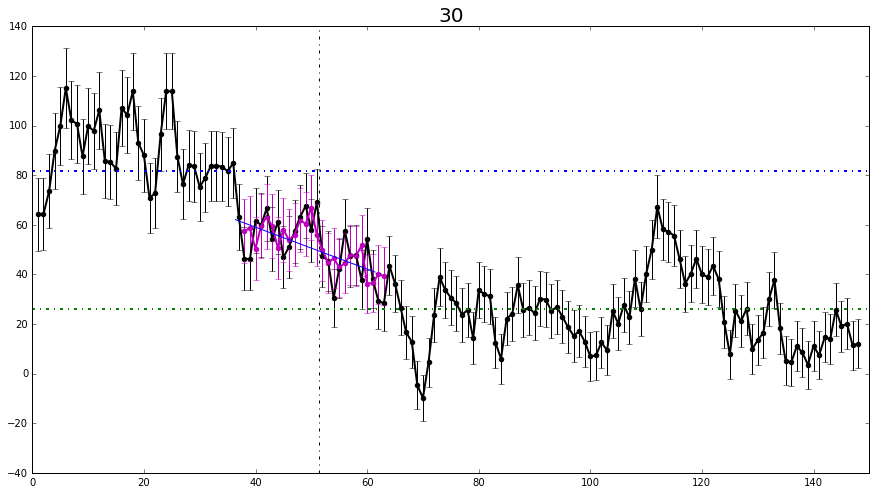

Chi Square =  2.1186031592
Chi Line =  0.118305182306
Square > Line = bad
Chi Diff =  2.00029797689
Chi Ratio =  17.9079488988
Chi Square v2 =  0.366236107135
Chi Line v2 =  0.23615505385
Square > Line = bad
Chi Diff  v2=  0.130081053285
Chi Ratio v2=  1.55082900478


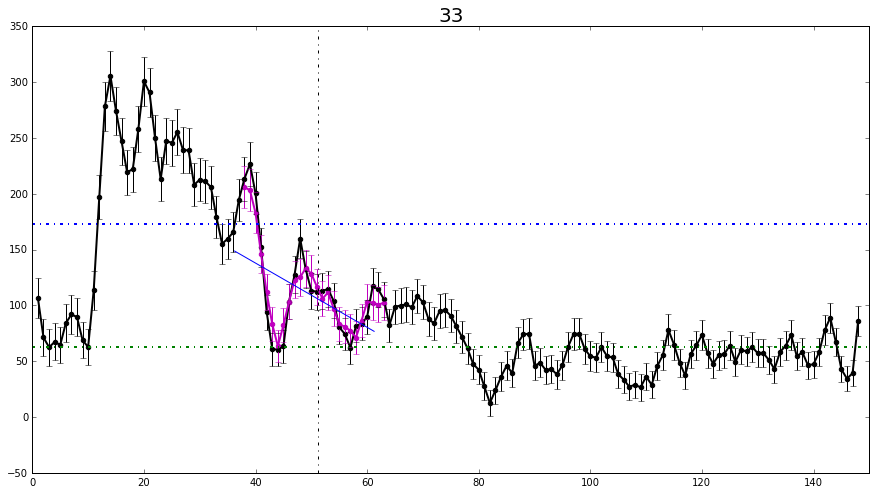

Chi Square =  0.989230814424
Chi Line =  28.4685176977
Square < Line = good
Chi Diff =  -27.4792868833
Chi Ratio =  0.0347482375067
Chi Square v2 =  0.144963274584
Chi Line v2 =  0.436701732467
Square < Line = good
Chi Diff  v2=  -0.291738457883
Chi Ratio v2=  0.331950307971


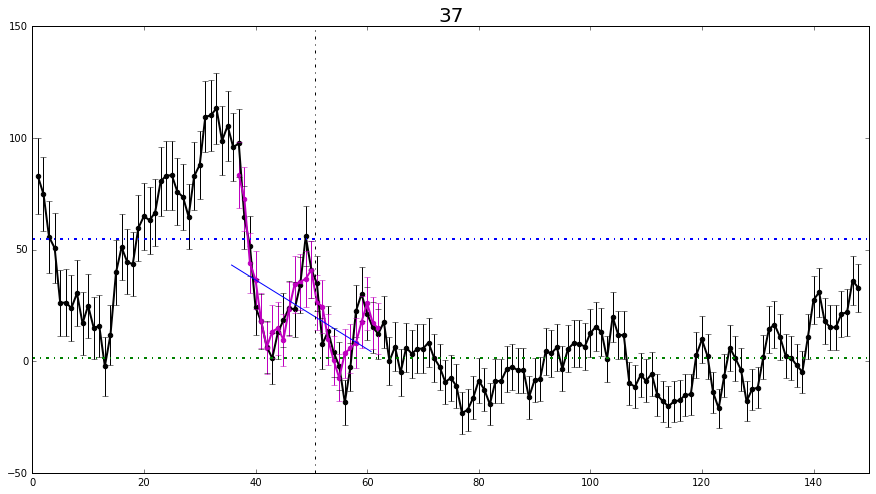

Chi Square =  0.869247378922
Chi Line =  13.0265807631
Square < Line = good
Chi Diff =  -12.1573333842
Chi Ratio =  0.0667287444596
Chi Square v2 =  0.166317600305
Chi Line v2 =  0.52134214598
Square < Line = good
Chi Diff  v2=  -0.355024545675
Chi Ratio v2=  0.319018137297


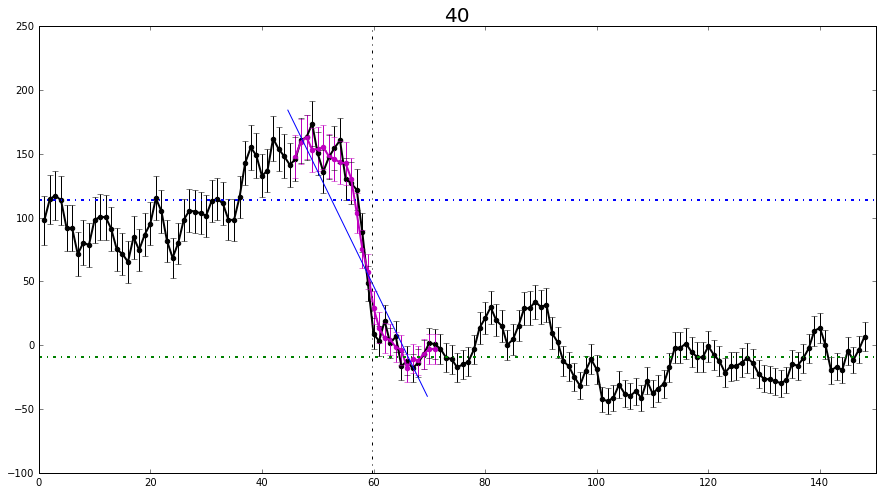

Chi Square =  1.28063443177
Chi Line =  0.0338121679797
Square > Line = bad
Chi Diff =  1.24682226379
Chi Ratio =  37.874957694
Chi Square v2 =  0.544874288927
Chi Line v2 =  0.0805395095615
Square > Line = bad
Chi Diff  v2=  0.464334779366
Chi Ratio v2=  6.76530428226


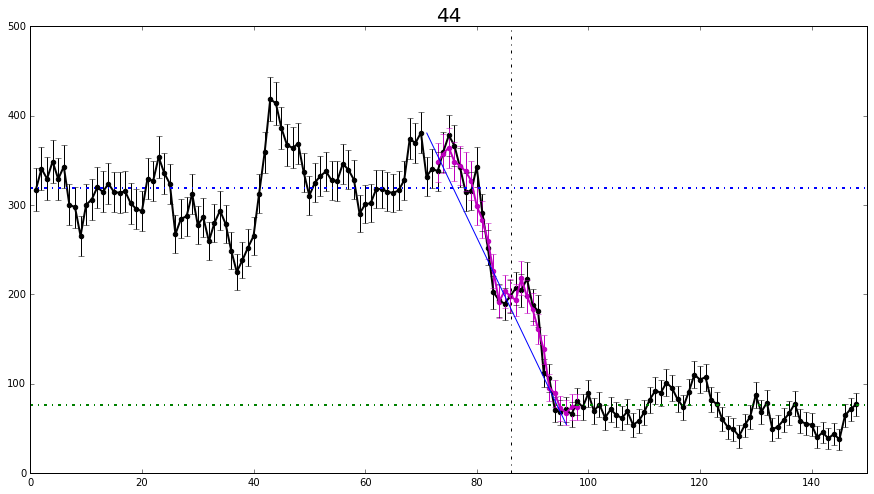

Chi Square =  1.51553139476
Chi Line =  0.289983194954
Square > Line = bad
Chi Diff =  1.22554819981
Chi Ratio =  5.22627318111
Chi Square v2 =  0.177278051471
Chi Line v2 =  0.240065100767
Square < Line = good
Chi Diff  v2=  -0.0627870492957
Chi Ratio v2=  0.73845823864


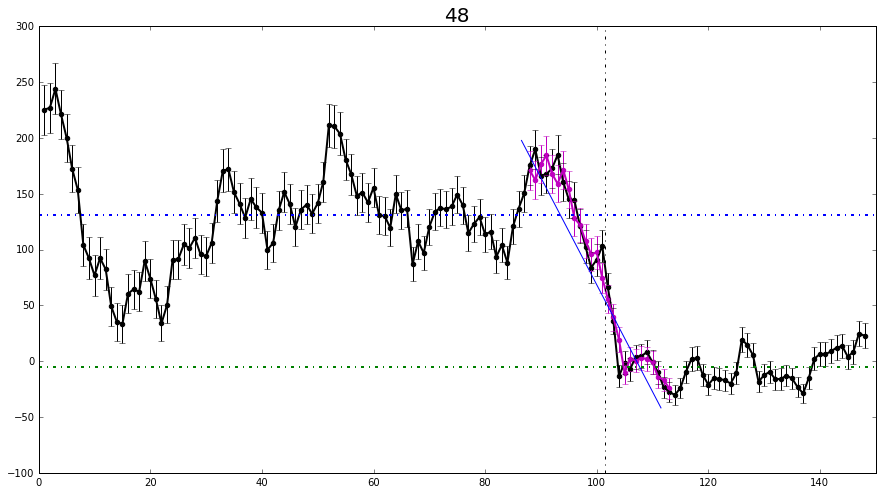

Chi Square =  2.08361339743
Chi Line =  3.99845641881
Square < Line = good
Chi Diff =  -1.91484302138
Chi Ratio =  0.521104441111
Chi Square v2 =  0.267506256622
Chi Line v2 =  0.292106681526
Square < Line = good
Chi Diff  v2=  -0.0246004249042
Chi Ratio v2=  0.915782738088


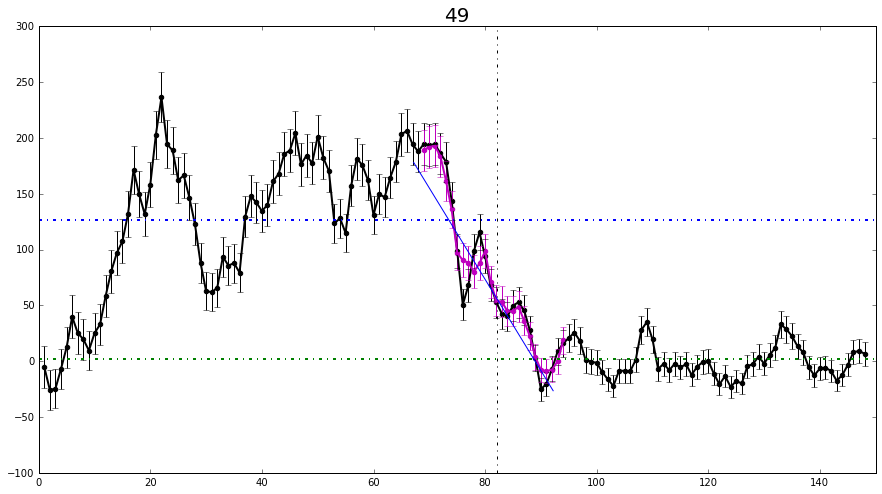

Chi Square =  2.09579013591
Chi Line =  0.17468705734
Square > Line = bad
Chi Diff =  1.92110307857
Chi Ratio =  11.9973979058
Chi Square v2 =  0.197005260973
Chi Line v2 =  0.631830824515
Square < Line = good
Chi Diff  v2=  -0.434825563542
Chi Ratio v2=  0.311800648733


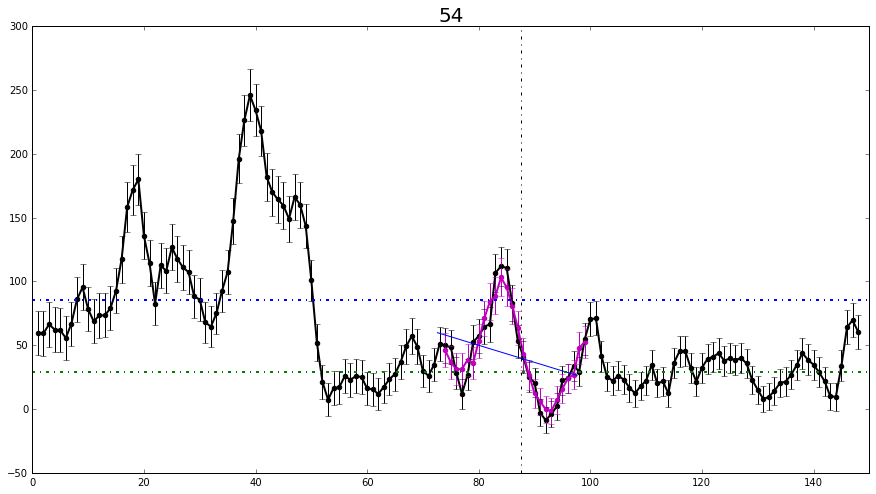

Chi Square =  1.3722218147
Chi Line =  0.0179294225593
Square > Line = bad
Chi Diff =  1.35429239214
Chi Ratio =  76.5346351872
Chi Square v2 =  0.112129865449
Chi Line v2 =  0.0525536960322
Square > Line = bad
Chi Diff  v2=  0.0595761694171
Chi Ratio v2=  2.1336247289


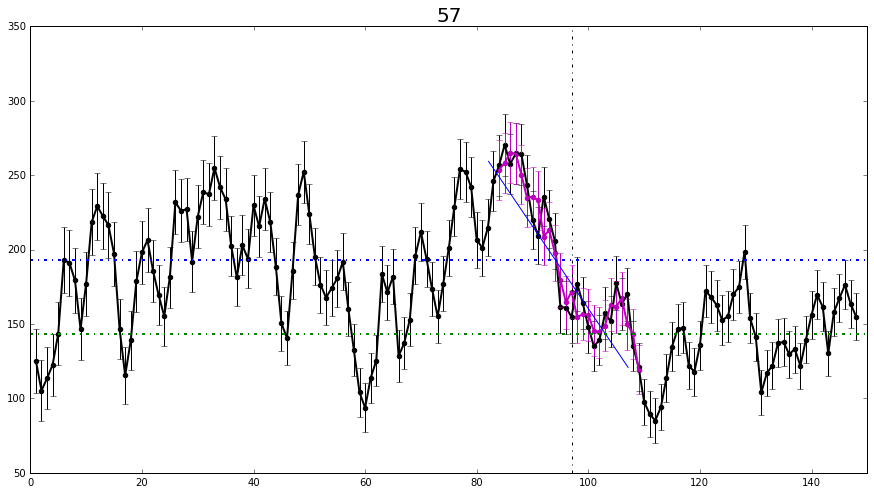

Chi Square =  1.50933856931
Chi Line =  2.26805831114
Square < Line = good
Chi Diff =  -0.758719741834
Chi Ratio =  0.665476086701
Chi Square v2 =  0.159417604367
Chi Line v2 =  0.128958469515
Square > Line = bad
Chi Diff  v2=  0.0304591348515
Chi Ratio v2=  1.23619336493


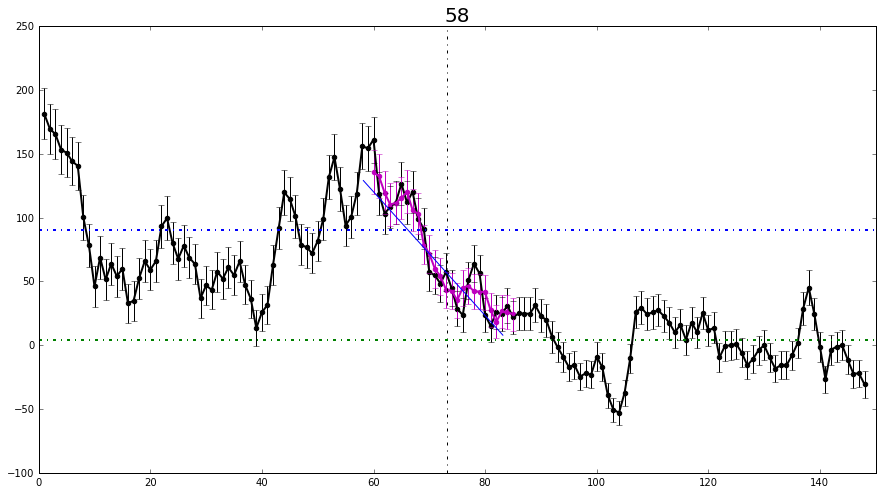

Chi Square =  3.59290276588
Chi Line =  0.0434984524867
Square > Line = bad
Chi Diff =  3.54940431339
Chi Ratio =  82.598404322
Chi Square v2 =  0.116235855911
Chi Line v2 =  0.148852921411
Square < Line = good
Chi Diff  v2=  -0.0326170654999
Chi Ratio v2=  0.780877223028


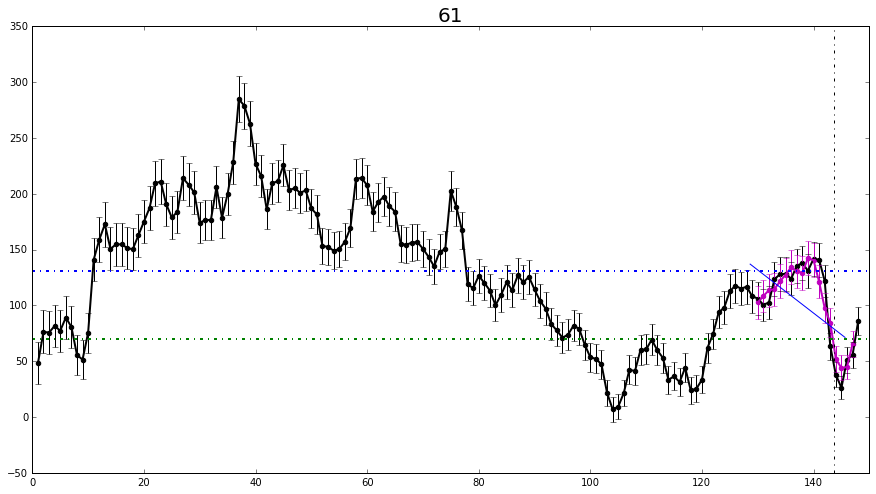

Chi Square =  0.928124799879
Chi Line =  7.97930773582
Square < Line = good
Chi Diff =  -7.05118293595
Chi Ratio =  0.11631645634
Chi Square v2 =  0.0718062500391
Chi Line v2 =  0.474930793444
Square < Line = good
Chi Diff  v2=  -0.403124543405
Chi Ratio v2=  0.151193081245


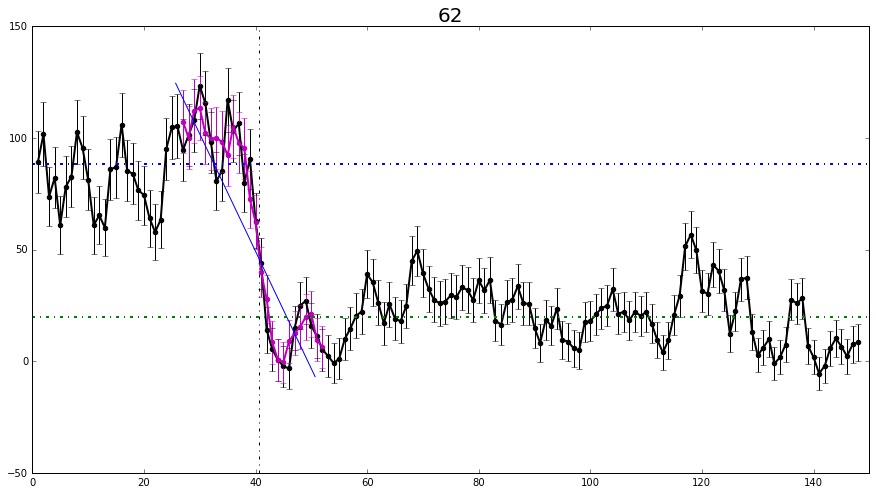

Chi Square =  0.872477648127
Chi Line =  48.8511268061
Square < Line = good
Chi Diff =  -47.9786491579
Chi Ratio =  0.0178599288321
Chi Square v2 =  0.212543123211
Chi Line v2 =  0.395488737693
Square < Line = good
Chi Diff  v2=  -0.182945614482
Chi Ratio v2=  0.537418902117


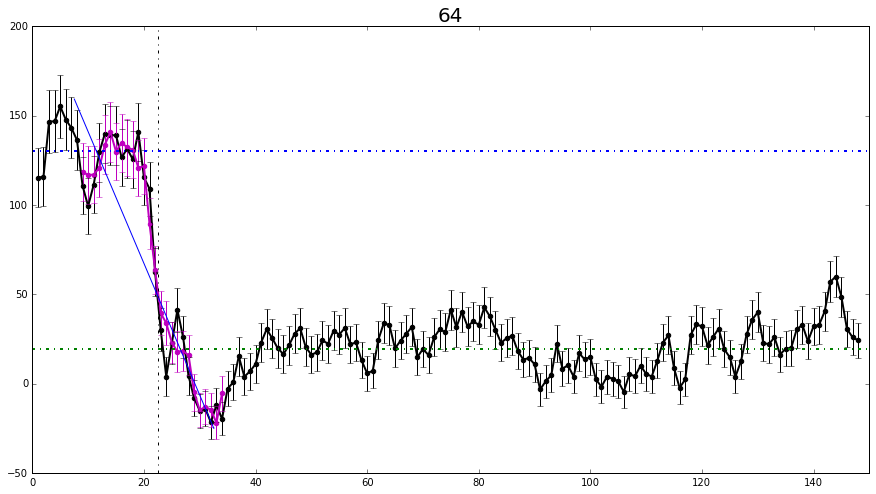

Chi Square =  2.54907020282
Chi Line =  32.2873273262
Square < Line = good
Chi Diff =  -29.7382571234
Chi Ratio =  0.0789495574243
Chi Square v2 =  0.347520639546
Chi Line v2 =  0.0449493638579
Square > Line = bad
Chi Diff  v2=  0.302571275689
Chi Ratio v2=  7.73138059629


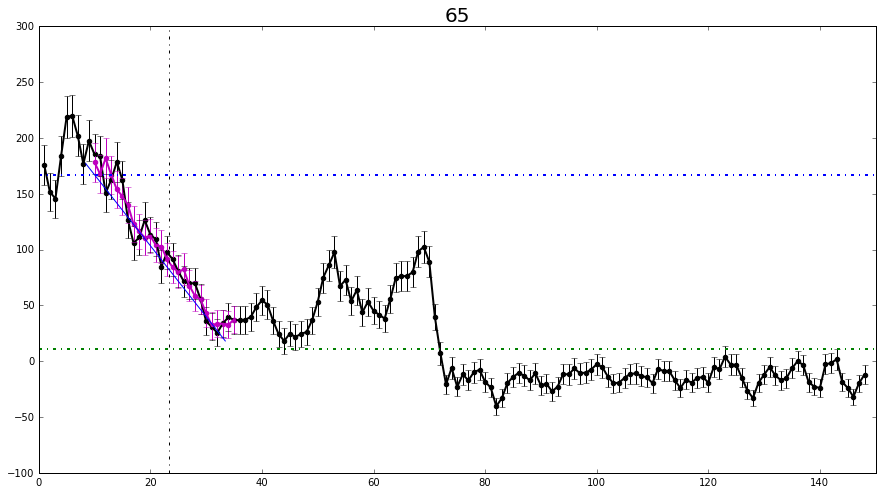

Chi Square =  2.05916124661
Chi Line =  16.1255466422
Square < Line = good
Chi Diff =  -14.0663853955
Chi Ratio =  0.127695593353
Chi Square v2 =  0.685593032285
Chi Line v2 =  1.24702626558
Square < Line = good
Chi Diff  v2=  -0.561433233299
Chi Ratio v2=  0.549782351187


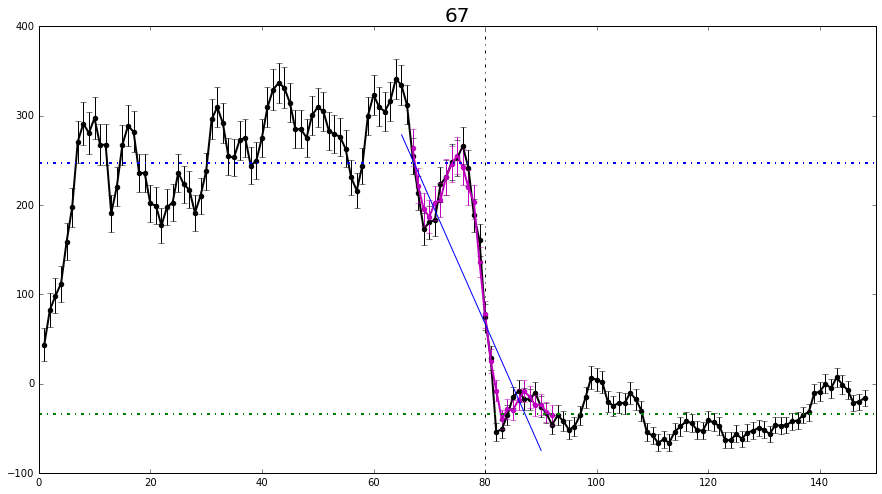

Chi Square =  0.989454482079
Chi Line =  5.36310829016
Square < Line = good
Chi Diff =  -4.37365380808
Chi Ratio =  0.184492728572
Chi Square v2 =  0.108674201701
Chi Line v2 =  0.983859752557
Square < Line = good
Chi Diff  v2=  -0.875185550856
Chi Ratio v2=  0.110457005095


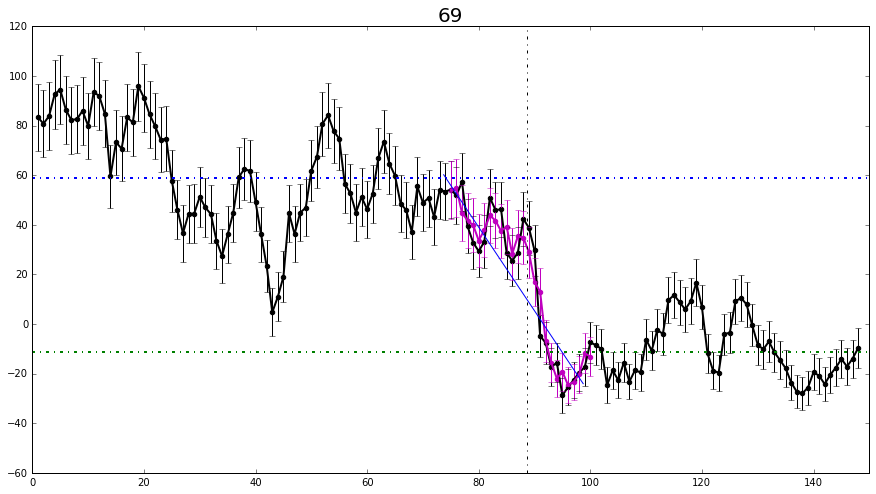

Chi Square =  4.48669414599
Chi Line =  0.0539788521972
Square > Line = bad
Chi Diff =  4.4327152938
Chi Ratio =  83.1194803773
Chi Square v2 =  0.222355435458
Chi Line v2 =  0.261140269313
Square < Line = good
Chi Diff  v2=  -0.0387848338552
Chi Ratio v2=  0.851478923732


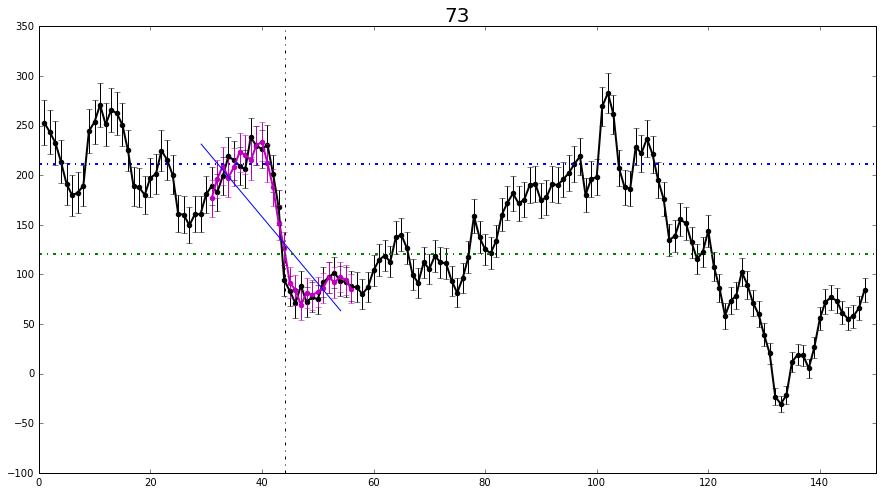

Chi Square =  1.72587884133
Chi Line =  2.89709647794
Square < Line = good
Chi Diff =  -1.1712176366
Chi Ratio =  0.595727085541
Chi Square v2 =  0.0950262031372
Chi Line v2 =  0.0612367367119
Square > Line = bad
Chi Diff  v2=  0.0337894664252
Chi Ratio v2=  1.55178424324


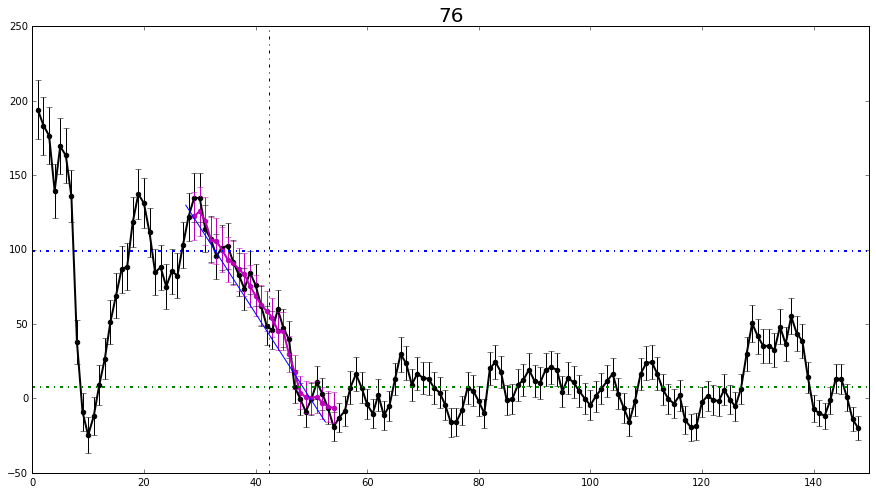

Chi Square =  1.78430681116
Chi Line =  1.1908156242
Square > Line = bad
Chi Diff =  0.593491186958
Chi Ratio =  1.49839049379
Chi Square v2 =  0.0613236307462
Chi Line v2 =  0.136728568727
Square < Line = good
Chi Diff  v2=  -0.0754049379812
Chi Ratio v2=  0.448506345945


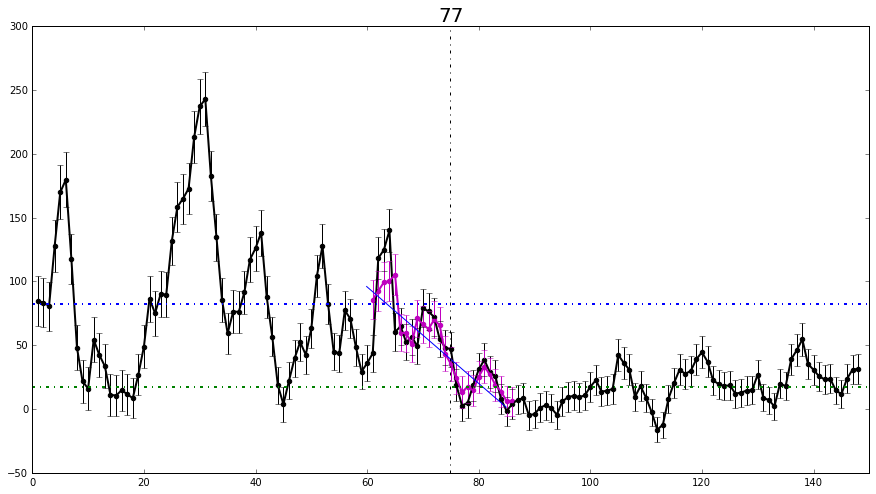

Chi Square =  1.32433888501
Chi Line =  0.0482591459103
Square > Line = bad
Chi Diff =  1.2760797391
Chi Ratio =  27.4422362855
Chi Square v2 =  0.127081796829
Chi Line v2 =  0.162187614941
Square < Line = good
Chi Diff  v2=  -0.0351058181114
Chi Ratio v2=  0.783548095678


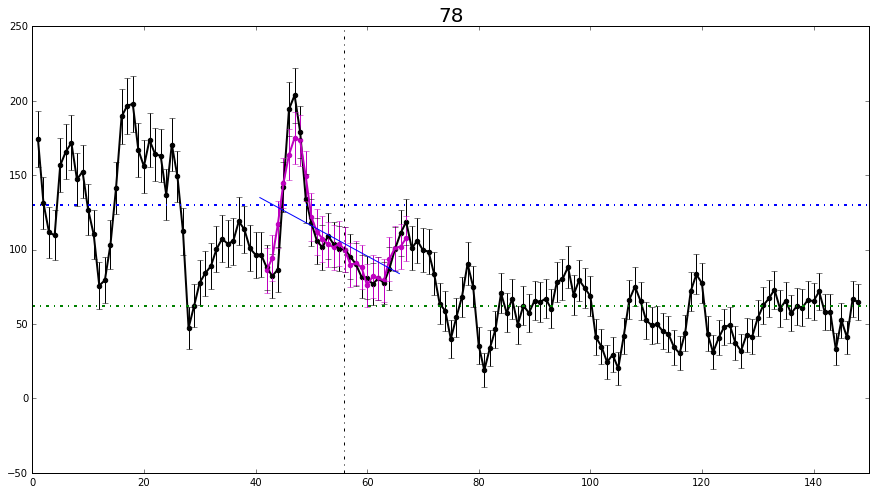

Chi Square =  2.4912994257
Chi Line =  4.39168560703
Square < Line = good
Chi Diff =  -1.90038618133
Chi Ratio =  0.567276360064
Chi Square v2 =  0.174332186245
Chi Line v2 =  0.184355954711
Square < Line = good
Chi Diff  v2=  -0.010023768466
Chi Ratio v2=  0.945628181733


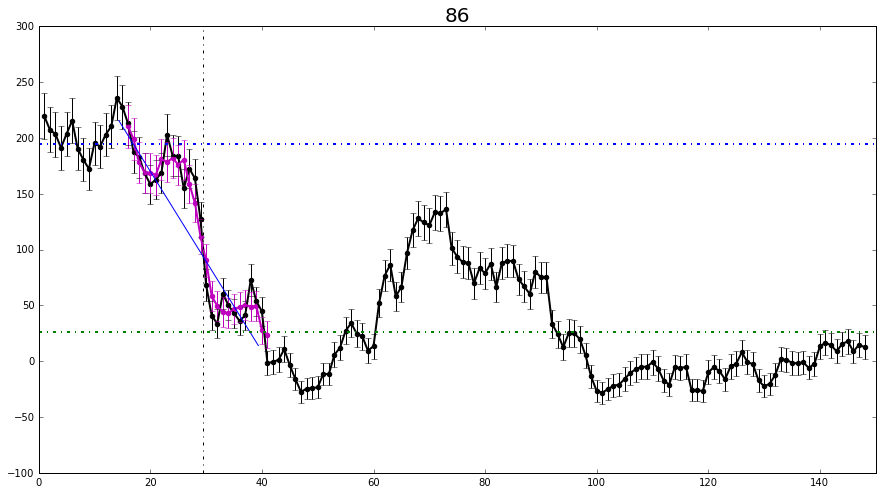

Chi Square =  1.43614670301
Chi Line =  0.0825637359449
Square > Line = bad
Chi Diff =  1.35358296706
Chi Ratio =  17.3944006599
Chi Square v2 =  0.0869821583498
Chi Line v2 =  0.127673003427
Square < Line = good
Chi Diff  v2=  -0.040690845077
Chi Ratio v2=  0.68128857327


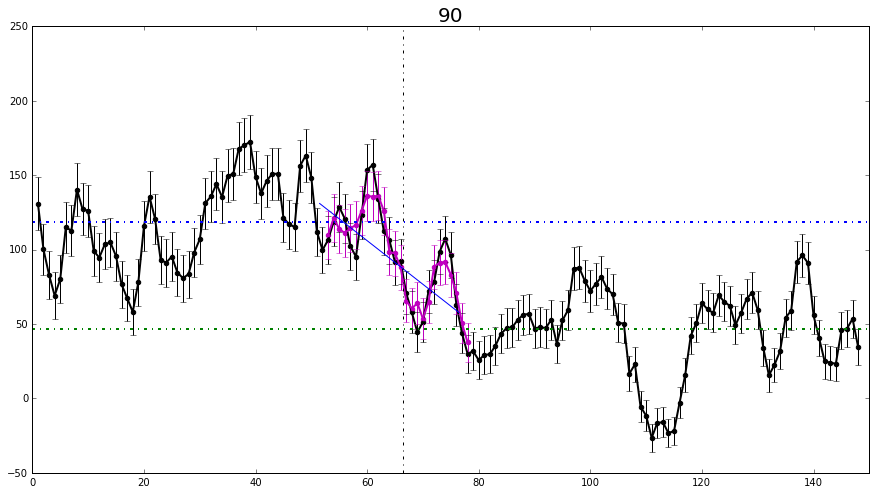

Chi Square =  0.705745698076
Chi Line =  0.0678037533774
Square > Line = bad
Chi Diff =  0.637941944699
Chi Ratio =  10.4086523669
Chi Square v2 =  0.0652522691778
Chi Line v2 =  0.0788481208069
Square < Line = good
Chi Diff  v2=  -0.0135958516291
Chi Ratio v2=  0.827569110209


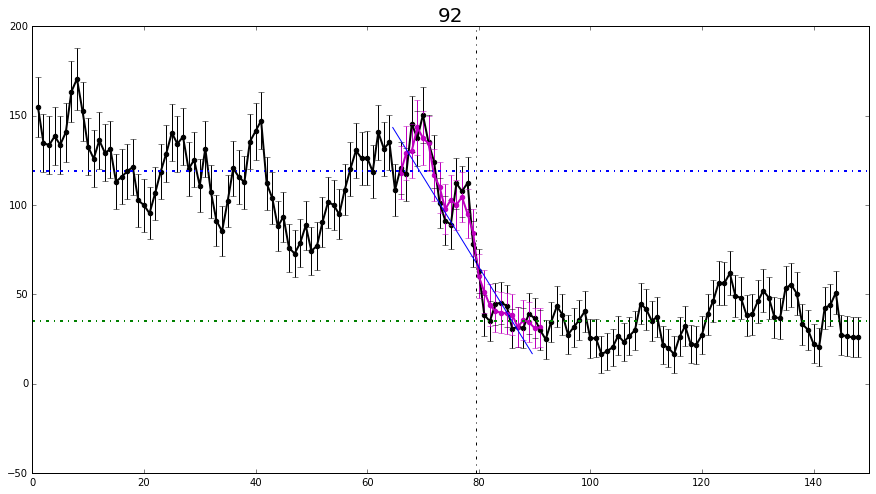

Chi Square =  2.12455238818
Chi Line =  185.927130627
Square < Line = good
Chi Diff =  -183.802578239
Chi Ratio =  0.011426801355
Chi Square v2 =  0.205508261342
Chi Line v2 =  0.695392160528
Square < Line = good
Chi Diff  v2=  -0.489883899186
Chi Ratio v2=  0.295528585174


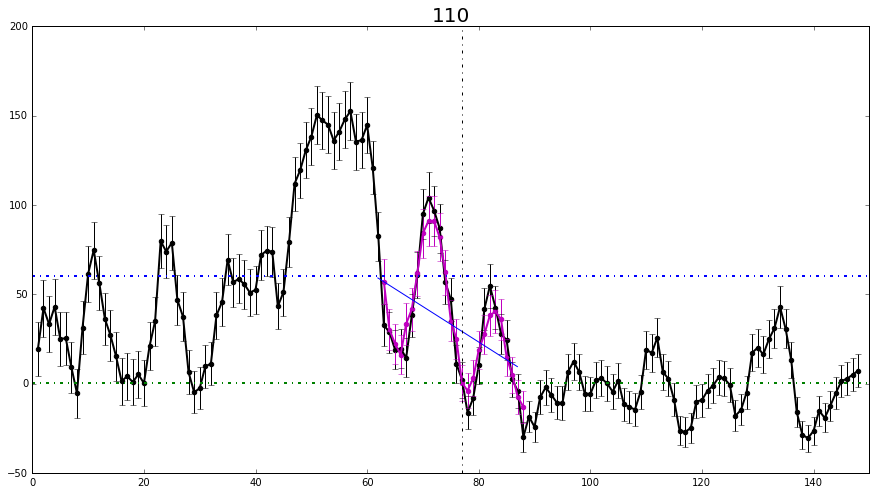

Chi Square =  1.24727897297
Chi Line =  0.044650109304
Square > Line = bad
Chi Diff =  1.20262886367
Chi Ratio =  27.9345110777
Chi Square v2 =  0.140020024795
Chi Line v2 =  0.146332535976
Square < Line = good
Chi Diff  v2=  -0.00631251118054
Chi Ratio v2=  0.956861875328


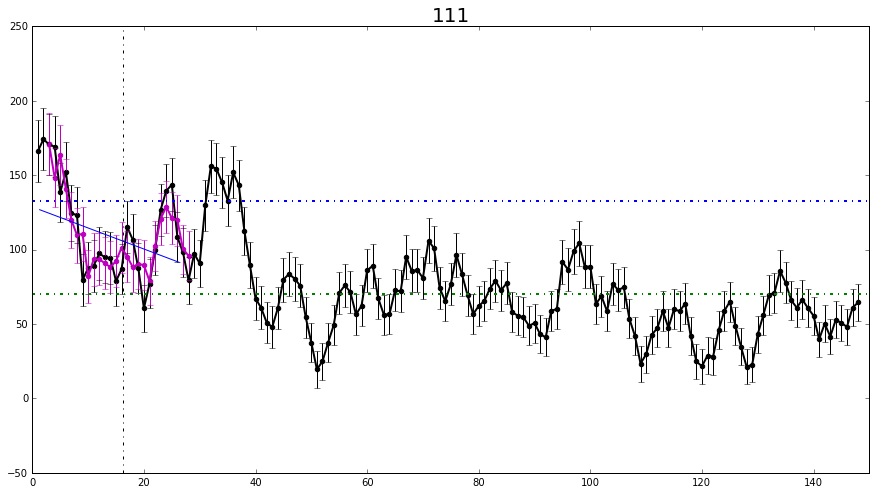

Chi Square =  0.735007505129
Chi Line =  0.333494458743
Square > Line = bad
Chi Diff =  0.401513046386
Chi Ratio =  2.20395717488
Chi Square v2 =  0.0544392985869
Chi Line v2 =  0.0906625660708
Square < Line = good
Chi Diff  v2=  -0.0362232674839
Chi Ratio v2=  0.600460597424


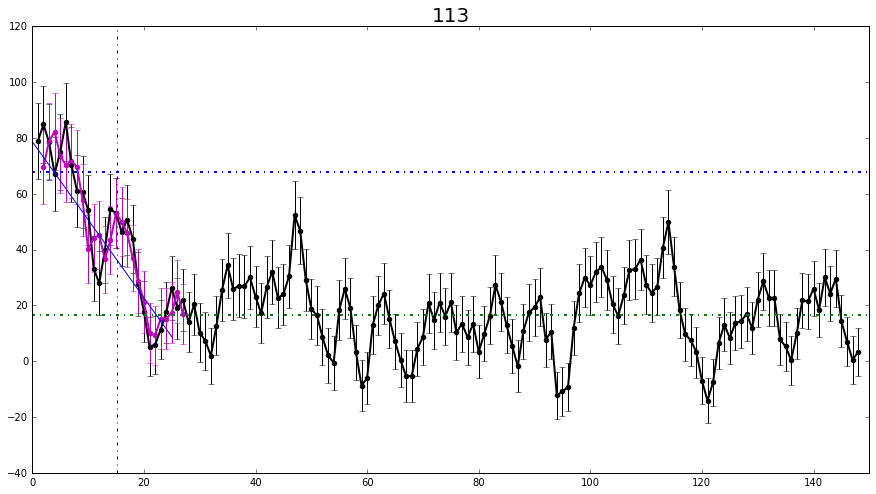

Chi Square =  1.52593231394
Chi Line =  2.55022510218
Square < Line = good
Chi Diff =  -1.02429278824
Chi Ratio =  0.598352009255
Chi Square v2 =  0.314732158139
Chi Line v2 =  0.198996264265
Square > Line = bad
Chi Diff  v2=  0.115735893874
Chi Ratio v2=  1.58159832448


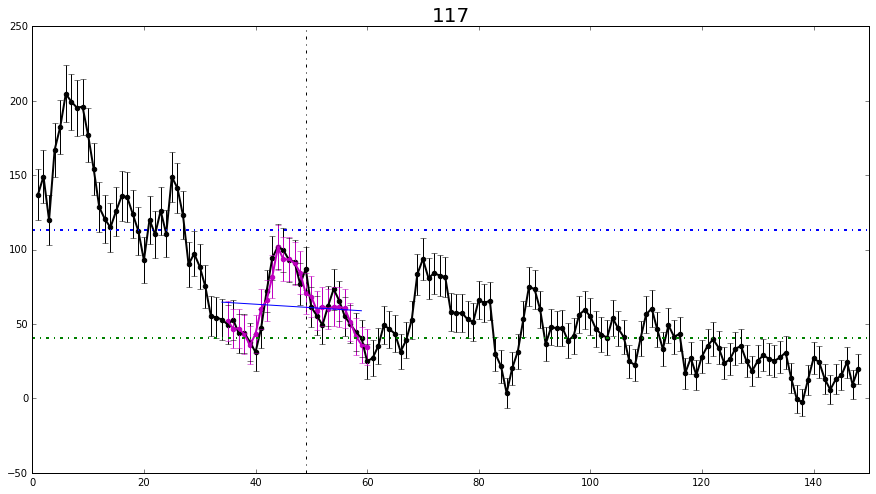

Chi Square =  0.717634624537
Chi Line =  0.213706480384
Square > Line = bad
Chi Diff =  0.503928144153
Chi Ratio =  3.35803866709
Chi Square v2 =  0.0838693341554
Chi Line v2 =  0.150872689697
Square < Line = good
Chi Diff  v2=  -0.0670033555417
Chi Ratio v2=  0.555894736972


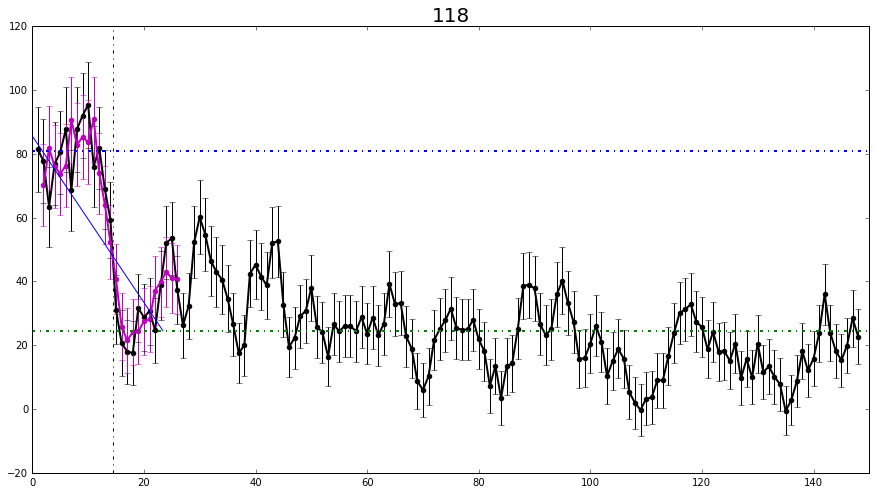

Chi Square =  0.9104105639
Chi Line =  0.6493694056
Square > Line = bad
Chi Diff =  0.2610411583
Chi Ratio =  1.4019917724
Chi Square v2 =  0.100404066503
Chi Line v2 =  0.0902246948921
Square > Line = bad
Chi Diff  v2=  0.0101793716105
Chi Ratio v2=  1.11282245535


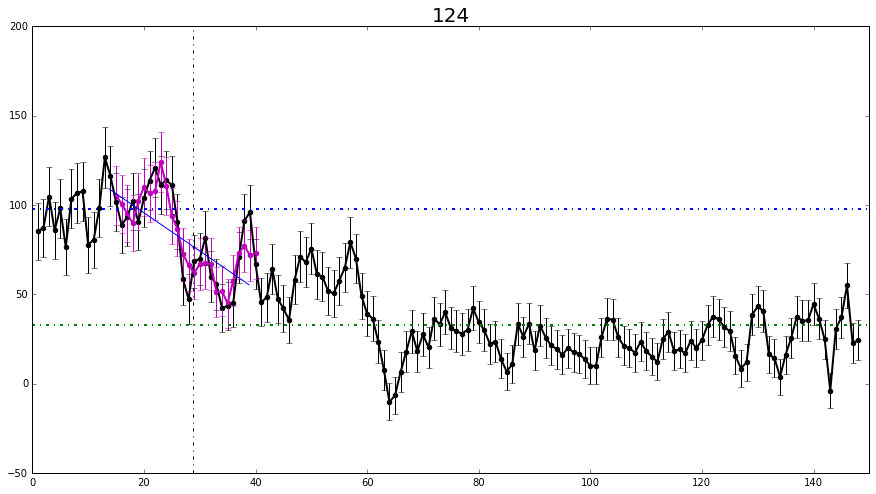

Chi Square =  1.04831619509
Chi Line =  7.83677637825
Square < Line = good
Chi Diff =  -6.78846018317
Chi Ratio =  0.133768802948
Chi Square v2 =  0.0855368145021
Chi Line v2 =  0.142043842129
Square < Line = good
Chi Diff  v2=  -0.0565070276273
Chi Ratio v2=  0.602186009754


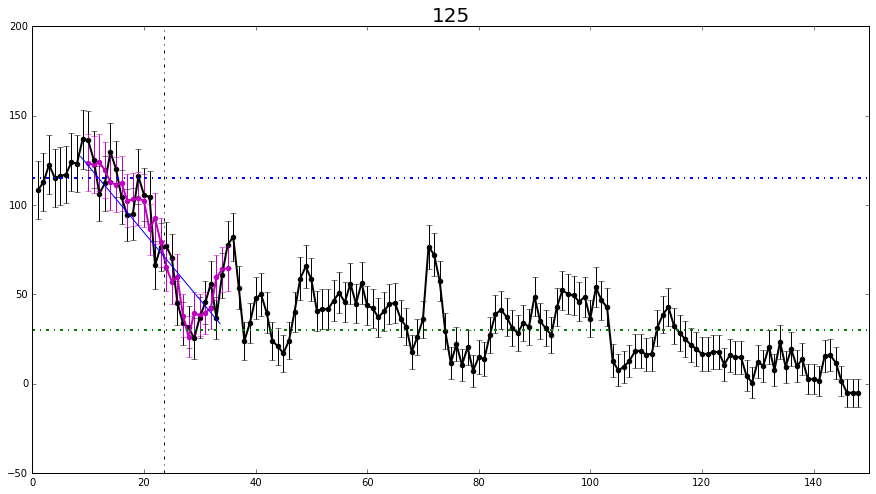

Chi Square =  0.835465556711
Chi Line =  16.6155348259
Square < Line = good
Chi Diff =  -15.7800692692
Chi Ratio =  0.0502821946729
Chi Square v2 =  0.0563519175399
Chi Line v2 =  0.437792883404
Square < Line = good
Chi Diff  v2=  -0.381440965864
Chi Ratio v2=  0.128718212827


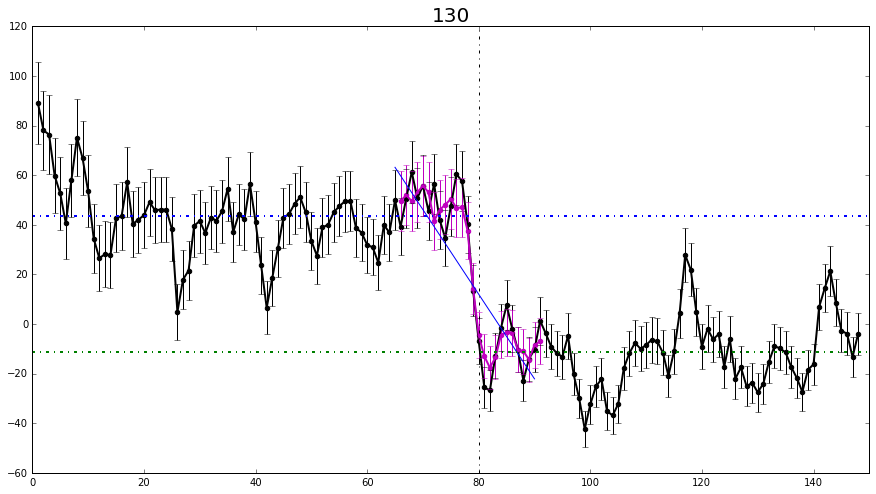

Chi Square =  1.04798140491
Chi Line =  0.0315963545098
Square > Line = bad
Chi Diff =  1.0163850504
Chi Ratio =  33.1677948666
Chi Square v2 =  0.208361260395
Chi Line v2 =  0.22630157532
Square < Line = good
Chi Diff  v2=  -0.0179403149257
Chi Ratio v2=  0.920723861952


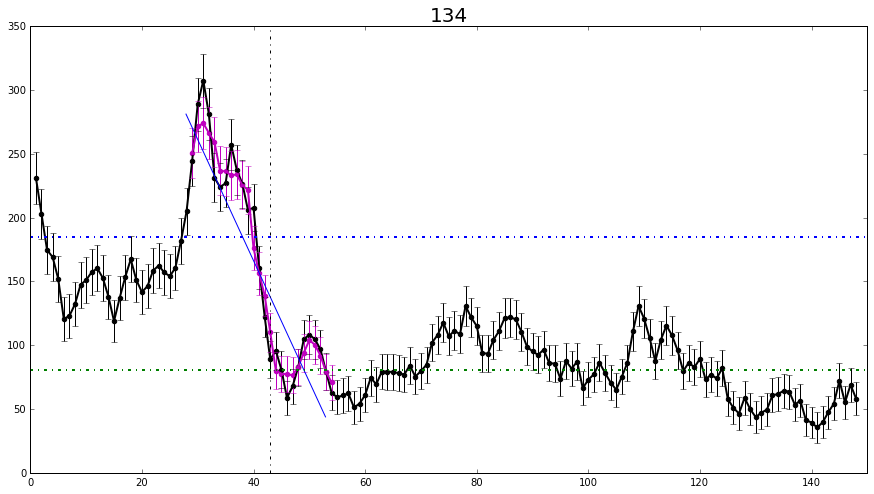

Chi Square =  1.02216061425
Chi Line =  6868.86514783
Square < Line = good
Chi Diff =  -6867.84298722
Chi Ratio =  0.000148810697583
Chi Square v2 =  0.131673314049
Chi Line v2 =  0.0990435296064
Square > Line = bad
Chi Diff  v2=  0.0326297844427
Chi Ratio v2=  1.32944892587


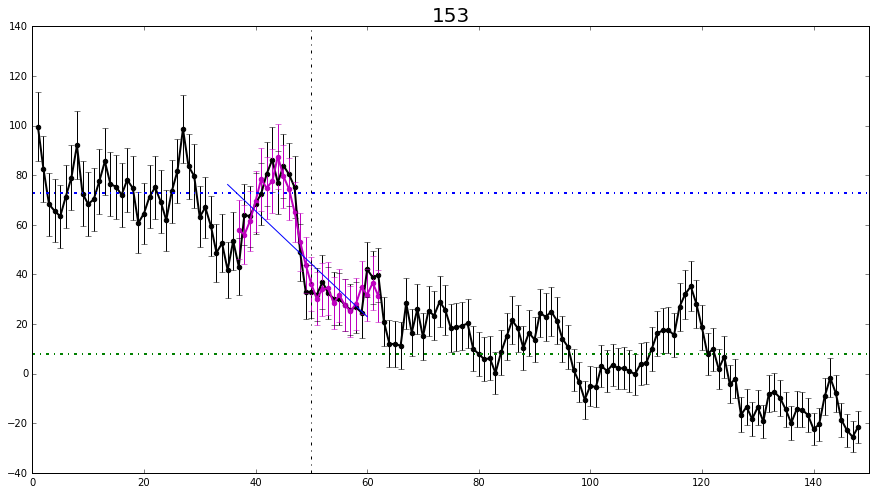

In [74]:
for x in range(0,len(Tau3)):
    if meanDif[x]>50:
        plt.figure(figsize=(15,8))
        vals =np.arange(0,len(areaSS[x]))
        plt.title(x,fontsize=20)
        print('Chi Square = ',chiSQUAR[x])
        print('Chi Line = ',chiLINE[x])
        if chiSQUAR[x]>chiLINE[x]:
            print('Square > Line = bad')
        else:
            print('Square < Line = good')   
        print('Chi Diff = ',chiDiff[x])
        print('Chi Ratio = ',chiRa[x])
        avg=3
        
        smo=running_mean(areaSS[x],avg)
        vsmo=running_mean(vals,avg)
        esmo=running_mean(errors[x],avg)
        plt.plot(vsmo,smo,color='k',linewidth=2)
        plt.scatter(vsmo,smo,color='k')
        plt.errorbar(vsmo,smo,yerr=esmo,color='k',fmt='.')
        
        cut = 15
        avg2=5
        Csmo=running_mean(areaSS[x][Tau3[x]-cut:Tau3[x]+cut],avg2)
        Cvsmo=running_mean(vals[Tau3[x]-cut:Tau3[x]+cut],avg2)
        Cesmo=running_mean(errors[x][Tau3[x]-cut:Tau3[x]+cut],avg2)
        
        plt.plot(Cvsmo,Csmo,color='m',linewidth=2)
        plt.scatter(Cvsmo,Csmo,color='m')
        plt.errorbar(Cvsmo,Csmo,yerr=Cesmo,color='m',fmt='.')

        chiHIGH = np.sum((Csmo[:cut] - MeanI[x])**2/abs(Cesmo[:cut])**2)/749
        chiLOW = np.sum((Csmo[cut:] - MeanE[x])**2/abs(Cesmo[cut:])**2)/749

        val = np.arange(0,len(Csmo),1)
        coefs=np.polyfit(val,Csmo,1)    
        ffit  = coefs[0]*val+coefs[1]
        chiFit  = np.sum((ffit - Csmo)**2/abs(ffit))/748
        
        
        print('Chi Square v2 = ',chiHIGH+chiLOW)
        print('Chi Line v2 = ',chiFit)
        if chiHIGH+chiLOW>chiFit:
            print('Square > Line = bad')
        else:
            print('Square < Line = good')   
        print('Chi Diff  v2= ',chiHIGH+chiLOW-chiFit)
        print('Chi Ratio v2= ',(chiHIGH+chiLOW)/chiFit)
        
        plt.plot(val+Tau3[x]-cut,ffit)
        
        #plt.plot(vals,areaS[x],color='m',linewidth=1)
        plt.axvline(Tau3[x],linestyle ='-.',color='k')
        plt.axhline(MeanI[x],linestyle ='-.',color='b',linewidth=2)
        plt.axhline(MeanE[x],linestyle ='-.',color='g',linewidth=2)
        
        plt.xlim(0,150)
        plt.show()

Chi Square =  7908.86437951
Chi Line =  11653.7009479
Square < Line = good
Chi Diff =  -3744.83656838
Chi Ratio =  0.678656884613


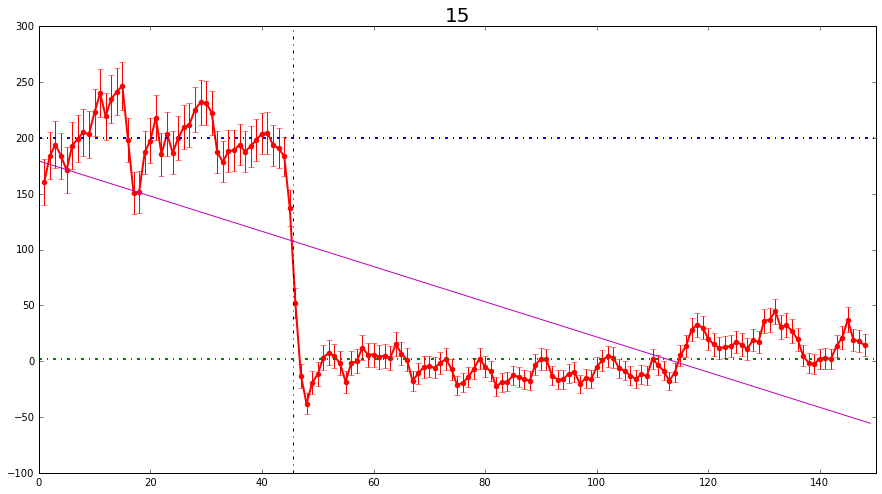

Chi Square =  17844.2676119
Chi Line =  4063.11360346
Square > Line = bad
Chi Diff =  13781.1540085
Chi Ratio =  4.39177176753


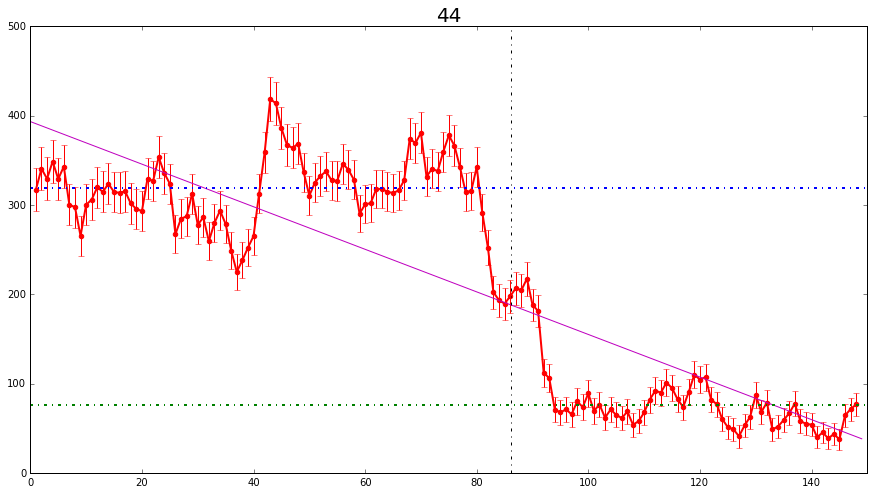

Chi Square =  20184.3925814
Chi Line =  10040.0609593
Square > Line = bad
Chi Diff =  10144.3316222
Chi Ratio =  2.01038546114


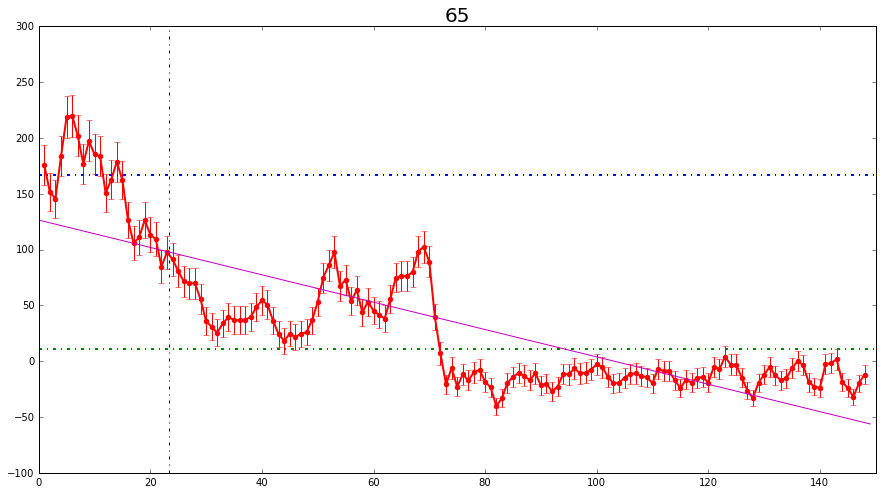

Chi Square =  26210.4876264
Chi Line =  23560.624411
Square > Line = bad
Chi Diff =  2649.86321534
Chi Ratio =  1.11246999099


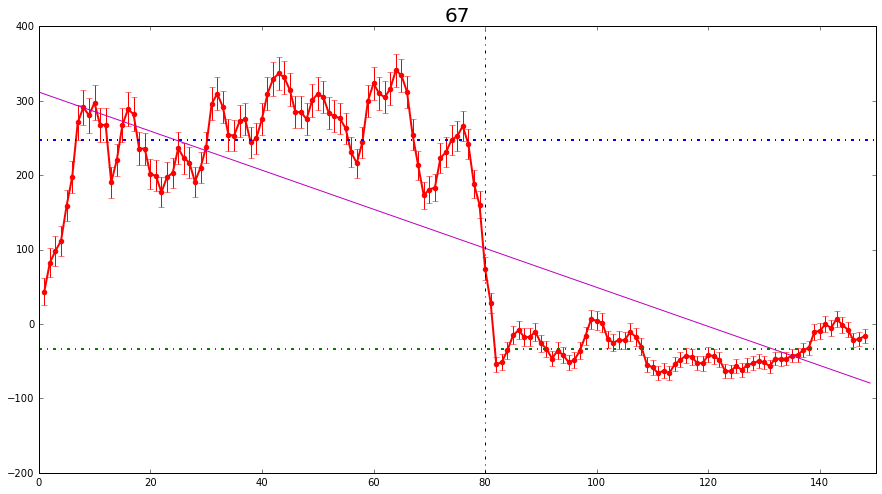

Chi Square =  23268.2160305
Chi Line =  10562.5382772
Square > Line = bad
Chi Diff =  12705.6777533
Chi Ratio =  2.20290004352


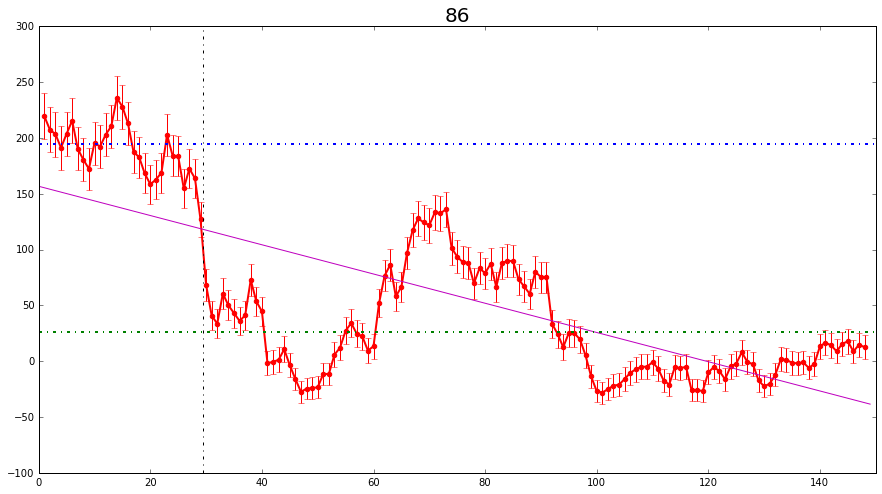

In [36]:
for x in range(0,len(Tau3)):
    if meanDif[x]>150:
        plt.figure(figsize=(15,8))
        vals =np.arange(0,len(areaSS[x]))
        plt.title(x,fontsize=20)
        print('Chi Square = ',chiSQUAR[x])
        print('Chi Line = ',chiLINE[x])
        if chiSQUAR[x]>chiLINE[x]:
            print('Square > Line = bad')
        else:
            print('Square < Line = good')
            
        print('Chi Diff = ',chiDiff[x])
        print('Chi Ratio = ',chiRa[x])
        avg=3
        smo=running_mean(areaSS[x],avg)
        vsmo=running_mean(vals,avg)
        esmo=running_mean(errors[x],avg)
        plt.plot(vsmo,smo,color='r',linewidth=2)
        plt.scatter(vsmo,smo,color='r')
        plt.errorbar(vsmo,smo,yerr=esmo,color='r',fmt='.')
        
        
        
        #plt.scatter(vals,areaSS[x],color='k')
        #plt.plot(vals,areaSS[x],color='k')
        #plt.errorbar(vals,areaSS[x],yerr=errors[x],color='k',fmt='.')
        plt.plot(vals,areaS[x],color='m',linewidth=1)
        #plt.scatter(vals,areaS[x],color='m',linewidth=1)
        
        plt.axvline(Tau3[x],linestyle ='-.',color='k')
        plt.axhline(MeanI[x],linestyle ='-.',color='b',linewidth=2)
        plt.axhline(MeanE[x],linestyle ='-.',color='g',linewidth=2)
        
        plt.xlim(0,150)
        plt.show()

In [ ]:
vals =np.arange(0,len(AREASS[0][0]))
valsf =np.arange(0,len(AREA[0][0]))
#vals = np.add.reduceat(vals2, np.arange(0, len(vals2), AVG))
Q=0
Offset=4
for x in range(0,len(AREASS[Q])):
    if MEAND[Q][x]>100 :#and CHIR[Q][x]<1:
        data = AREASS[Q][x]
        plt.figure(figsize=(15,6))
        vals =np.arange(0,len(AREASS[Q][x]))

        plt.title(x,fontsize=20)
        print('Chi Square = ',CHISQUARE[Q][x])
        print('Chi Line = ',CHILINE[Q][x])
        print('Chi Diff = ',CHIDIF[Q][x])
        print('Chi Ratio = ',CHIR[Q][x])
        #print('tau =', str(data[x][1])+' '+"+/-"+' '+str(Dtau[x]/7.75))
        TauH   = LIFETIME[Q][x]
        #Data = running_mean(Signal[x],4)
        DataLeft  = AREASS[Q][x][:int(TauH)-Offset]
        DataRight = AREASS[Q][x][int(TauH)+Offset:]
        #meanI  = np.mean(DataLeft)
        #meanE  = np.mean(DataRight)
        #print('mean front=',meanI)
        #print('mean back=',meanE)
        #plt.title(str(x) +'\n'+str(PairsMade[x]),fontsize=20)


        plt.scatter(vals,AREASS[Q][x],color='k')
        plt.errorbar(vals,AREASS[Q][x],yerr=ERRORS[Q][x],color='k',fmt='.')

        #plt.scatter(valsf,AREA[Q][x],color='r')
        #plt.scatter(valsf,AREAB[Q][x],color='m')


        plt.plot(vals,AREASS[Q][x],color='k')
        
        val = np.arange(0,len(data),1)
        #coefs=np.polyfit(val,data,1)    
        #ffit  = coefs[0]*val+coefs[1]
        #plt.scatter(vals,ffit,color='g')
        plt.plot(vals,AREA[Q][x],color='m',linewidth=2)
        
        #plt.axhline(0,linestyle ='-.',color='k')
        plt.axvline(LIFETIME[Q][x],linestyle ='-.',color='k')

        plt.axhline(MEANI[Q][x],linestyle ='-.',color='b',linewidth=2)
        plt.axhline(MEANE[Q][x],linestyle ='-.',color='g',linewidth=2)
        #plt.axvline(LIFETIME[Q][x],linestyle ='-.',color='k')

        #plt.plot(running_mean(vals,K),running_mean(data[x][0],K),color='grey')
        #plt.scatter(running_mean(vals,K),running_mean(data[x][0],K),color='grey')

        #val = np.arange(0,len(running_mean(data[x][0],4)) ,1)
        ##fit=np.polyfit(val,running_mean(data[x][0],4),1)  
        #plt.plot(val,fit[1]+val*fit[0],color='b')
        #plt.plot(val,(np.polyval(fit, val) - running_mean(data[x][0],4)))

        #plt.axhline(np.mean(data[x][0]),linestyle ='-',color='r')

        #plt.axvline(data[x][1],linestyle ='-.',color='k')
        plt.xlim(0,150)
        #plt.ylim(0,50)
        plt.tight_layout()
        plt.show()

In [7]:
for a in range(0,len(AllPairs)):
    if AllPairs[a][0] == 119:
        print(AllPairs[a])
        print(a)

    else:
        None
    

(119.0, 55.0)
15
(119.0, 85.0)
47


In [8]:
len(aa)

150

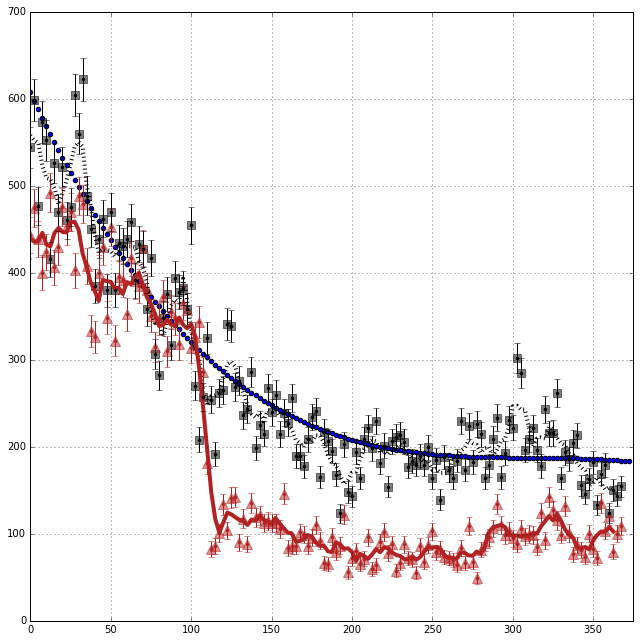

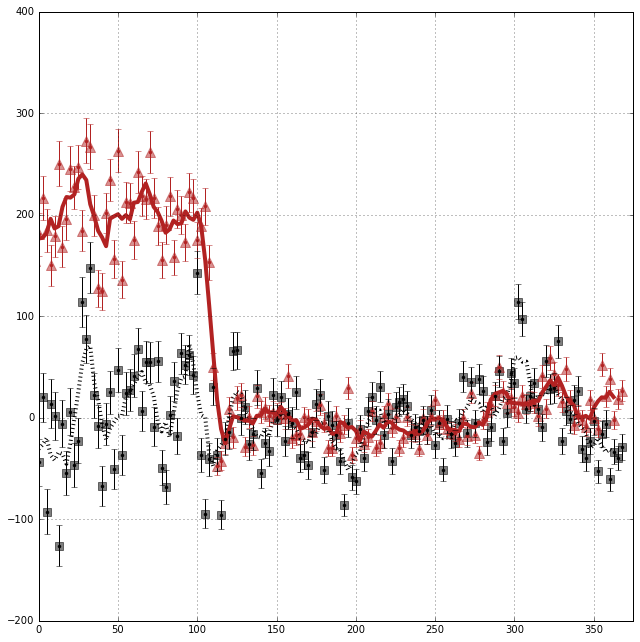

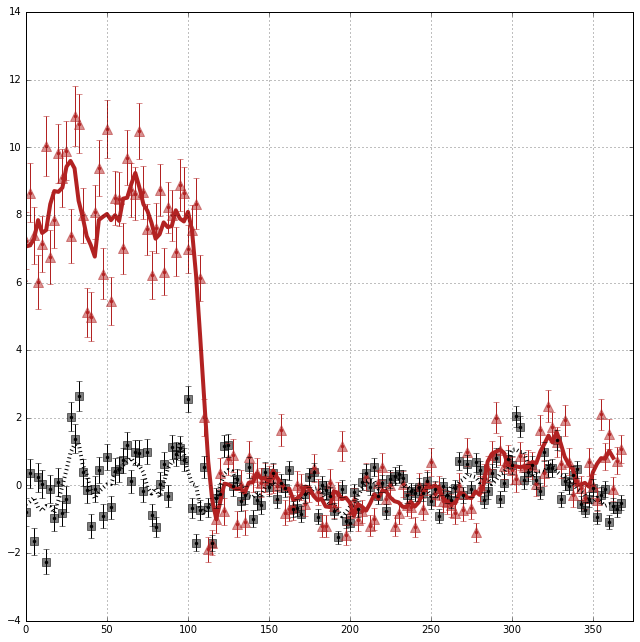

In [93]:
#Raw plot
dataFull = np.add.reduceat(SignalF[15], np.arange(0, len(SignalF[15]), 5))
dataFullB = np.add.reduceat(BackGF[15], np.arange(0, len(BackGF[15]), 5))
times    = np.arange(0,len(dataFull))*2.5

K=5
Atime = running_mean(times,K)
Adat  = running_mean(dataFull,K)
AdatB = running_mean(dataFullB,K)

fig, ax = plt.subplots(figsize=(9,9))

b1 = ax.scatter(times-5,dataFullB, color='k',marker='s',label='Background', alpha=0.5,s=75)
bf1 = ax.plot(Atime-5,AdatB,color='k',label='moving avg',linestyle=':',linewidth=4)

s1 = ax.scatter(times-5,dataFull,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
sf1 = ax.plot(Atime-5,Adat,color='firebrick',label='moving avg',linestyle='-',linewidth=4)

valsF =np.arange(0,len(dataFull))*2.5
coefsF = poly.polyfit(valsF,dataFullB, 3)
ffitF  = poly.polyval(valsF, coefsF)
plt.scatter(valsF,ffitF)

baerry = np.sqrt(dataFull)
naerry = np.sqrt(dataFullB)
ax.errorbar(times-5,dataFull,yerr=baerry,color='firebrick',fmt='.')
ax.errorbar(times-5,dataFullB,yerr=naerry,color='k',fmt='.')

ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()


#Subtracted plot
fig, ax = plt.subplots(figsize=(9,9))

dataSub  = dataFull-ffitF*(25/56)
dataSubB = dataFullB-ffitF
Adat  = running_mean(dataSub,K)
AdatB = running_mean(dataSubB,K)

ax.scatter(times-5,dataSubB, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub,yerr=baerry,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB,yerr=naerry,color='k',fmt='.')



ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()


#per pixel plot

fig, ax = plt.subplots(figsize=(9,9))

bknorm=56
signorm=25

ax.scatter(times-5,dataSubB/bknorm, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB/bknorm,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub/signorm,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat/signorm,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub/signorm,yerr=baerry/signorm,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB/bknorm,yerr=naerry/bknorm,color='k',fmt='.')




ax.set_xlim(0,375)
#ax.set_ylim(0,15)
ax.grid(True)
plt.tight_layout()
plt.show()

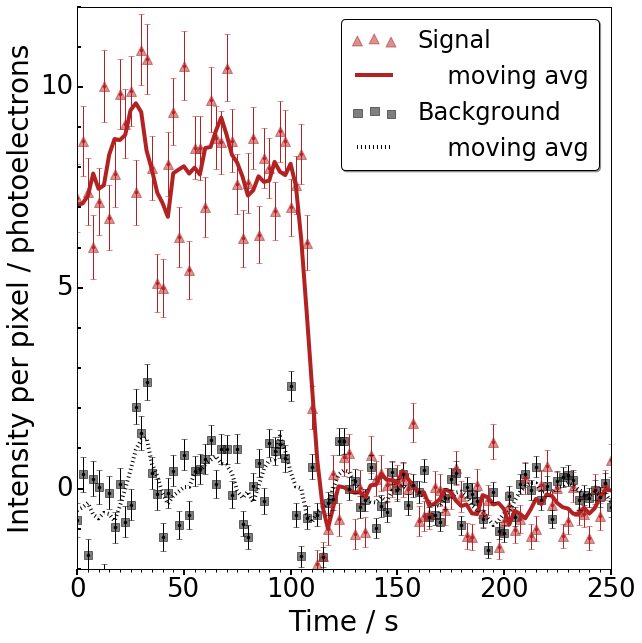

In [8]:
#per pixel plot

dataFull = np.add.reduceat(SignalF[15], np.arange(0, len(SignalF[15]), 5))#[a:b]
dataFullB = np.add.reduceat(BackGF[15], np.arange(0, len(BackGF[15]), 5))
times    = np.arange(0,len(dataFull))*2.5

K=5
Atime = running_mean(times,K)
Adat  = running_mean(dataFull,K)
AdatB = running_mean(dataFullB,K)


valsF =np.arange(0,len(dataFull))*2.5
coefsF = poly.polyfit(valsF,dataFullB, 3)
ffitF  = poly.polyval(valsF, coefsF)

baerry = np.sqrt(dataFull)
naerry = np.sqrt(dataFullB)

dataSub  = dataFull-ffitF*(25/56)
dataSubB = dataFullB-ffitF
Adat  = running_mean(dataSub,K)
AdatB = running_mean(dataSubB,K)


fig, ax = plt.subplots(figsize=(9,9))

bknorm=56
signorm=25
#plt.axhline(0,linewidth=1,color='black',linestyle='-')

ax.scatter(times-5,dataSubB/bknorm, color='k',marker='s',label='Background', alpha=0.5,s=75)
ax.plot(Atime-5,AdatB/bknorm,color='k',label='moving avg',linestyle=':',linewidth=4)

ax.scatter(times-5,dataSub/signorm,color='firebrick',marker='^',label='Signal', alpha=0.5,s=100)
ax.plot(Atime-5,Adat/signorm,color='firebrick',label='moving avg',linestyle='-',linewidth=4)
ax.errorbar(times-5,dataSub/signorm,yerr=baerry/signorm,color='firebrick',fmt='.')
ax.errorbar(times-5,dataSubB/bknorm,yerr=naerry/bknorm,color='k',fmt='.')



ax.set_xlabel(r'Time / s', fontsize=28)
ax.set_ylabel('Intensity per pixel / photoelectrons', fontsize=28)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[1], handles[2], handles[0]]
aa = '\n   25 pixels'
bb = '\n   56 pixels'

labels = [labels[3], '    '+labels[1], labels[2], '    '+labels[0]]
ax.legend(handles,labels,fontsize=24,shadow=True, fancybox=True)

plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)

xmajor_ticks = np.arange(0, 260, 50)
xminor_ticks = np.arange(0, 250, 5)
ymajor_ticks = np.arange(0, 20, 5)
yminor_ticks = np.arange(-5, 20, 1)
ax.tick_params(axis = 'x', which = 'major', direction='out',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'x', which = 'minor', direction='out',width=1,length=3,top="off",right='off')

ax.tick_params(axis = 'y', which = 'major', direction='in',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'y', which = 'minor', direction='in',width=2,length=4,top="off",right='off')

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor = True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor = True)

ax.set_xlim(0,250)
ax.set_ylim(-2,12)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/singlebaplots/Ba-Photobleach12.png')
plt.show()